In [1]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
 
# load all images in a directory into memory
def load_images(path, size=(256,256)):
    data_list = list()
# enumerate filenames in directory, assume all are images
    for filename in listdir(path):
    # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # store
        data_list.append(pixels)
    return asarray(data_list)
 
# dataset path
path = 'pix2pix experiment/' 

# load source domain images
dataA = load_images(path + 'real_world_masks/')
print('Loaded dataA: ', dataA.shape)

# load target domain images
dataB = load_images(path + 'New dataset/')
print('Loaded dataB: ', dataB.shape)

# save as compressed numpy array
filename = 'target_source.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

Loaded dataA:  (400, 256, 256, 3)
Loaded dataB:  (400, 256, 256, 3)
Saved dataset:  target_source.npz


### Loading the dataset
### Source domain -> Smoke Images
### Traget domain -> Binary masks

Loaded:  (400, 256, 256, 3) (400, 256, 256, 3)


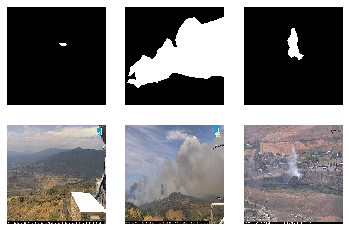

In [2]:
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('target_source.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(src_images[i].astype('uint8'))
    
# plot target image
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

### Train a pix2pix Model 

#### Discriminator

In [3]:
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=image_shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [4]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g
 
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
# image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

In [5]:
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [6]:
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [7]:
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [8]:
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [9]:
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [10]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

In [ ]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot




# load image data
dataset = load_real_samples('target_source.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (400, 256, 256, 3) (400, 256, 256, 3)
>1, d1[0.225] d2[0.830] g[63.357]
>2, d1[0.418] d2[1.252] g[28.068]
>3, d1[0.357] d2[0.779] g[27.457]
>4, d1[0.316] d2[0.744] g[20.522]
>5, d1[0.315] d2[0.437] g[24.197]
>6, d1[0.317] d2[0.375] g[55.583]
>7, d1[0.419] d2[0.654] g[35.205]
>8, d1[0.376] d2[0.436] g[28.373]
>9, d1[0.327] d2[0.386] g[32.140]
>10, d1[0.292] d2[0.361] g[39.723]
>11, d1[0.320] d2[0.384] g[62.449]
>12, d1[0.382] d2[0.351] g[35.742]
>13, d1[0.349] d2[0.362] g[27.403]
>14, d1[0.452] d2[0.413] g[23.799]
>15, d1[0.317] d2[0.287] g[36.713]
>16, d1[0.293] d2[0.280] g[42.051]
>17, d1[0.210] d2[0.281] g[24.155]
>18, d1[0.268] d2[0.351] g[27.176]
>19, d1[0.370] d2[0.525] g[19.418]
>20, d1[0.336] d2[0.369] g[24.958]
>21, d1[0.175] d2[0.367] g[35.758]
>22, d1[0.260] d2[0.623] g[23.961]
>23, d1[0.337] d2[0.383] g[22.129]
>24, d1[0.368] d2[0.322] g[18.556]
>25, d1[0.577] d2[0.297] g[27.503]
>26, d1[0.499] d2[0.369] g[27.465]
>27, d1[0.373] d2[0.402] g[23.006]
>28, d1[0.368] d2[0

>231, d1[0.015] d2[0.034] g[14.388]
>232, d1[0.014] d2[0.029] g[20.684]
>233, d1[0.079] d2[0.043] g[40.340]
>234, d1[0.019] d2[0.164] g[32.311]
>235, d1[0.035] d2[0.056] g[22.484]
>236, d1[0.028] d2[0.025] g[19.247]
>237, d1[0.030] d2[0.018] g[18.864]
>238, d1[0.016] d2[0.036] g[35.538]
>239, d1[0.083] d2[0.053] g[37.676]
>240, d1[0.089] d2[0.026] g[17.518]
>241, d1[0.041] d2[0.291] g[21.834]
>242, d1[0.073] d2[0.026] g[39.175]
>243, d1[0.290] d2[0.034] g[23.146]
>244, d1[0.013] d2[0.056] g[42.136]
>245, d1[0.013] d2[0.032] g[21.928]
>246, d1[0.044] d2[0.034] g[25.745]
>247, d1[0.011] d2[0.040] g[20.387]
>248, d1[0.009] d2[0.036] g[26.447]
>249, d1[0.058] d2[0.018] g[25.579]
>250, d1[0.011] d2[0.027] g[36.278]
>251, d1[0.039] d2[0.101] g[27.847]
>252, d1[0.009] d2[0.023] g[41.835]
>253, d1[0.031] d2[0.045] g[18.009]
>254, d1[0.029] d2[0.025] g[25.307]
>255, d1[0.011] d2[0.024] g[23.237]
>256, d1[0.010] d2[0.016] g[34.263]
>257, d1[0.010] d2[0.021] g[20.318]
>258, d1[0.203] d2[0.571] g[

>459, d1[0.349] d2[0.249] g[22.546]
>460, d1[0.036] d2[0.124] g[15.757]
>461, d1[0.033] d2[1.864] g[32.835]
>462, d1[0.085] d2[0.035] g[29.047]
>463, d1[0.067] d2[0.045] g[19.245]
>464, d1[0.032] d2[0.191] g[21.168]
>465, d1[0.130] d2[0.012] g[37.107]
>466, d1[1.733] d2[0.037] g[20.371]
>467, d1[0.796] d2[0.211] g[23.915]
>468, d1[0.542] d2[0.293] g[19.161]
>469, d1[0.012] d2[1.341] g[27.111]
>470, d1[0.090] d2[0.096] g[45.892]
>471, d1[0.021] d2[0.082] g[22.151]
>472, d1[0.073] d2[0.055] g[25.658]
>473, d1[0.050] d2[0.082] g[21.995]
>474, d1[0.019] d2[0.050] g[29.223]
>475, d1[0.011] d2[0.038] g[19.491]
>476, d1[0.096] d2[0.034] g[41.338]
>477, d1[0.013] d2[0.092] g[33.235]
>478, d1[1.273] d2[0.148] g[16.886]
>479, d1[0.008] d2[0.179] g[47.194]
>480, d1[0.007] d2[0.105] g[18.551]
>481, d1[0.035] d2[0.071] g[32.772]
>482, d1[0.013] d2[0.051] g[33.730]
>483, d1[0.028] d2[0.039] g[42.696]
>484, d1[0.037] d2[0.194] g[31.967]
>485, d1[0.881] d2[0.156] g[13.929]
>486, d1[0.008] d2[0.130] g[

>687, d1[0.035] d2[0.028] g[28.591]
>688, d1[0.013] d2[0.043] g[19.988]
>689, d1[0.035] d2[0.045] g[22.198]
>690, d1[0.009] d2[0.035] g[30.362]
>691, d1[0.015] d2[0.041] g[15.238]
>692, d1[0.008] d2[0.035] g[24.425]
>693, d1[0.009] d2[0.050] g[26.544]
>694, d1[0.024] d2[0.036] g[16.227]
>695, d1[0.021] d2[0.033] g[16.411]
>696, d1[0.012] d2[0.036] g[28.494]
>697, d1[0.008] d2[0.032] g[27.000]
>698, d1[0.030] d2[0.044] g[25.941]
>699, d1[0.020] d2[0.050] g[42.602]
>700, d1[0.039] d2[0.216] g[34.812]
>701, d1[0.022] d2[0.018] g[25.452]
>702, d1[0.018] d2[0.022] g[22.484]
>703, d1[1.245] d2[0.031] g[18.556]
>704, d1[0.555] d2[0.200] g[39.624]
>705, d1[0.005] d2[0.200] g[28.313]
>706, d1[0.003] d2[0.078] g[28.884]
>707, d1[0.028] d2[0.043] g[23.962]
>708, d1[0.013] d2[0.042] g[15.727]
>709, d1[0.006] d2[0.042] g[20.286]
>710, d1[0.014] d2[0.033] g[13.773]
>711, d1[0.014] d2[0.033] g[18.086]
>712, d1[0.015] d2[0.032] g[16.456]
>713, d1[0.004] d2[0.028] g[27.930]
>714, d1[0.016] d2[0.029] g[

>915, d1[0.012] d2[0.023] g[40.959]
>916, d1[0.027] d2[0.034] g[27.449]
>917, d1[0.010] d2[0.058] g[22.109]
>918, d1[0.009] d2[0.021] g[39.046]
>919, d1[0.012] d2[0.065] g[24.625]
>920, d1[0.013] d2[0.053] g[25.777]
>921, d1[0.035] d2[0.028] g[40.091]
>922, d1[0.080] d2[0.056] g[25.462]
>923, d1[0.034] d2[0.061] g[23.330]
>924, d1[0.076] d2[0.021] g[35.945]
>925, d1[0.035] d2[0.014] g[21.637]
>926, d1[0.016] d2[0.025] g[29.678]
>927, d1[0.014] d2[0.077] g[43.894]
>928, d1[0.028] d2[0.007] g[31.862]
>929, d1[0.080] d2[0.008] g[33.407]
>930, d1[0.033] d2[0.011] g[33.235]
>931, d1[0.051] d2[0.015] g[18.236]
>932, d1[0.011] d2[0.057] g[31.370]
>933, d1[0.019] d2[0.017] g[35.734]
>934, d1[0.075] d2[0.064] g[20.889]
>935, d1[0.010] d2[0.016] g[25.548]
>936, d1[0.064] d2[0.009] g[24.096]
>937, d1[0.030] d2[0.012] g[41.032]
>938, d1[0.796] d2[0.121] g[21.424]
>939, d1[0.003] d2[0.034] g[26.338]
>940, d1[0.007] d2[0.019] g[44.784]
>941, d1[0.008] d2[0.068] g[31.140]
>942, d1[0.046] d2[0.040] g[

>1139, d1[0.020] d2[0.017] g[24.867]
>1140, d1[0.003] d2[0.020] g[46.169]
>1141, d1[0.002] d2[0.023] g[26.097]
>1142, d1[0.008] d2[0.017] g[32.498]
>1143, d1[0.002] d2[0.020] g[36.406]
>1144, d1[0.020] d2[0.018] g[31.859]
>1145, d1[0.003] d2[0.049] g[25.996]
>1146, d1[0.033] d2[0.024] g[19.955]
>1147, d1[0.019] d2[0.016] g[19.667]
>1148, d1[0.014] d2[0.020] g[17.497]
>1149, d1[0.003] d2[0.016] g[27.800]
>1150, d1[0.007] d2[0.014] g[22.327]
>1151, d1[0.007] d2[0.012] g[21.499]
>1152, d1[0.014] d2[0.013] g[14.371]
>1153, d1[0.281] d2[0.060] g[39.924]
>1154, d1[0.002] d2[0.036] g[26.495]
>1155, d1[0.002] d2[0.034] g[25.052]
>1156, d1[0.002] d2[0.019] g[26.692]
>1157, d1[0.002] d2[0.013] g[33.388]
>1158, d1[0.002] d2[0.011] g[24.999]
>1159, d1[0.005] d2[0.012] g[21.499]
>1160, d1[0.002] d2[0.009] g[26.677]
>1161, d1[0.004] d2[0.010] g[27.768]
>1162, d1[0.005] d2[0.010] g[23.199]
>1163, d1[0.002] d2[0.033] g[21.505]
>1164, d1[0.004] d2[0.039] g[17.110]
>1165, d1[0.004] d2[0.009] g[17.738]
>

>1361, d1[0.003] d2[0.011] g[32.029]
>1362, d1[0.005] d2[0.016] g[29.355]
>1363, d1[0.003] d2[0.013] g[22.393]
>1364, d1[0.004] d2[0.009] g[17.627]
>1365, d1[0.005] d2[0.057] g[29.744]
>1366, d1[0.005] d2[0.011] g[38.984]
>1367, d1[0.004] d2[0.008] g[27.430]
>1368, d1[0.017] d2[0.009] g[29.541]
>1369, d1[0.003] d2[0.010] g[26.522]
>1370, d1[0.004] d2[0.012] g[24.378]
>1371, d1[0.004] d2[0.009] g[27.767]
>1372, d1[0.011] d2[0.009] g[38.163]
>1373, d1[0.005] d2[0.046] g[29.272]
>1374, d1[0.005] d2[0.012] g[30.565]
>1375, d1[0.007] d2[0.020] g[32.539]
>1376, d1[0.005] d2[0.010] g[24.521]
>1377, d1[0.064] d2[0.862] g[40.028]
>1378, d1[0.786] d2[0.036] g[30.160]
>1379, d1[0.013] d2[0.066] g[25.177]
>1380, d1[0.916] d2[0.283] g[23.057]
>1381, d1[0.027] d2[0.102] g[33.936]
>1382, d1[0.008] d2[0.094] g[27.175]
>1383, d1[0.030] d2[0.036] g[37.243]
>1384, d1[0.234] d2[0.087] g[33.712]
>1385, d1[0.006] d2[0.566] g[34.831]
>1386, d1[0.024] d2[0.016] g[23.559]
>1387, d1[0.134] d2[0.015] g[22.433]
>

>1583, d1[0.006] d2[0.157] g[17.683]
>1584, d1[0.103] d2[0.051] g[19.924]
>1585, d1[0.276] d2[0.057] g[44.254]
>1586, d1[0.005] d2[0.114] g[27.783]
>1587, d1[0.012] d2[0.075] g[27.565]
>1588, d1[0.031] d2[0.138] g[26.928]
>1589, d1[0.012] d2[0.028] g[19.811]
>1590, d1[0.019] d2[0.029] g[33.210]
>1591, d1[0.016] d2[0.023] g[31.427]
>1592, d1[0.063] d2[0.059] g[19.448]
>1593, d1[0.010] d2[0.030] g[18.936]
>1594, d1[0.015] d2[0.114] g[16.857]
>1595, d1[0.022] d2[0.034] g[14.389]
>1596, d1[0.033] d2[0.081] g[22.666]
>1597, d1[0.013] d2[0.019] g[25.707]
>1598, d1[0.007] d2[0.055] g[30.374]
>1599, d1[0.139] d2[0.053] g[36.227]
>1600, d1[0.017] d2[0.057] g[28.588]
>1601, d1[0.008] d2[0.040] g[26.731]
>1602, d1[0.005] d2[0.030] g[29.206]
>1603, d1[0.008] d2[0.022] g[15.841]
>1604, d1[0.007] d2[0.022] g[37.873]
>1605, d1[0.009] d2[0.021] g[21.290]
>1606, d1[0.028] d2[0.024] g[22.416]
>1607, d1[0.007] d2[0.025] g[18.632]
>1608, d1[0.005] d2[0.018] g[29.065]
>1609, d1[0.007] d2[0.016] g[21.149]
>

>1805, d1[0.028] d2[0.045] g[29.324]
>1806, d1[0.022] d2[0.014] g[27.875]
>1807, d1[0.029] d2[0.022] g[26.203]
>1808, d1[0.030] d2[0.019] g[21.165]
>1809, d1[0.040] d2[0.022] g[50.939]
>1810, d1[0.036] d2[0.009] g[25.330]
>1811, d1[0.016] d2[0.010] g[28.583]
>1812, d1[0.496] d2[0.036] g[33.353]
>1813, d1[0.009] d2[0.059] g[26.433]
>1814, d1[0.007] d2[0.094] g[22.648]
>1815, d1[0.011] d2[0.018] g[47.997]
>1816, d1[0.012] d2[0.045] g[19.402]
>1817, d1[0.038] d2[0.046] g[31.442]
>1818, d1[0.011] d2[0.048] g[22.957]
>1819, d1[0.047] d2[0.121] g[19.518]
>1820, d1[0.013] d2[0.036] g[38.627]
>1821, d1[0.014] d2[0.047] g[36.714]
>1822, d1[0.023] d2[0.036] g[27.290]
>1823, d1[0.045] d2[0.335] g[18.145]
>1824, d1[0.183] d2[0.024] g[16.281]
>1825, d1[0.029] d2[0.030] g[21.154]
>1826, d1[0.014] d2[0.028] g[29.546]
>1827, d1[0.021] d2[0.022] g[29.453]
>1828, d1[0.728] d2[1.082] g[18.031]
>1829, d1[0.024] d2[0.620] g[37.036]
>1830, d1[0.080] d2[0.065] g[20.722]
>1831, d1[0.296] d2[0.049] g[23.573]
>

>2027, d1[0.026] d2[0.022] g[17.649]
>2028, d1[0.024] d2[0.017] g[18.736]
>2029, d1[0.046] d2[0.071] g[21.791]
>2030, d1[0.009] d2[0.015] g[22.562]
>2031, d1[0.014] d2[0.009] g[38.509]
>2032, d1[0.016] d2[0.014] g[19.943]
>2033, d1[0.016] d2[0.014] g[24.989]
>2034, d1[0.010] d2[0.015] g[38.894]
>2035, d1[0.017] d2[0.019] g[41.401]
>2036, d1[0.011] d2[0.016] g[18.259]
>2037, d1[0.016] d2[0.013] g[20.303]
>2038, d1[0.010] d2[0.014] g[25.614]
>2039, d1[0.013] d2[0.013] g[20.708]
>2040, d1[0.025] d2[0.057] g[22.853]
>2041, d1[0.010] d2[0.013] g[19.580]
>2042, d1[0.024] d2[0.021] g[22.134]
>2043, d1[0.930] d2[0.025] g[34.468]
>2044, d1[0.004] d2[0.105] g[23.833]
>2045, d1[0.005] d2[0.025] g[22.971]
>2046, d1[0.004] d2[0.031] g[36.565]
>2047, d1[0.004] d2[0.020] g[21.691]
>2048, d1[0.006] d2[1.243] g[22.816]
>2049, d1[0.018] d2[0.016] g[38.822]
>2050, d1[0.362] d2[0.057] g[34.766]
>2051, d1[0.027] d2[0.031] g[15.581]
>2052, d1[0.019] d2[0.036] g[26.051]
>2053, d1[0.018] d2[0.030] g[24.506]
>

>2249, d1[0.005] d2[0.011] g[17.515]
>2250, d1[0.008] d2[0.012] g[33.477]
>2251, d1[0.006] d2[0.011] g[27.898]
>2252, d1[0.010] d2[0.019] g[18.348]
>2253, d1[0.007] d2[0.012] g[31.111]
>2254, d1[0.016] d2[0.094] g[18.014]
>2255, d1[0.008] d2[0.015] g[25.320]
>2256, d1[0.004] d2[0.014] g[27.632]
>2257, d1[0.008] d2[0.012] g[36.606]
>2258, d1[0.003] d2[0.011] g[24.011]
>2259, d1[0.026] d2[0.012] g[21.518]
>2260, d1[0.018] d2[0.007] g[31.919]
>2261, d1[0.010] d2[0.013] g[23.378]
>2262, d1[0.007] d2[0.013] g[26.422]
>2263, d1[0.005] d2[0.007] g[21.702]
>2264, d1[0.006] d2[0.009] g[30.390]
>2265, d1[0.008] d2[0.013] g[20.017]
>2266, d1[0.007] d2[0.011] g[26.083]
>2267, d1[0.007] d2[0.016] g[22.198]
>2268, d1[0.005] d2[0.015] g[29.278]
>2269, d1[0.004] d2[0.015] g[29.846]
>2270, d1[0.006] d2[0.020] g[26.044]
>2271, d1[0.006] d2[0.010] g[19.932]
>2272, d1[0.008] d2[0.015] g[40.921]
>2273, d1[0.003] d2[0.017] g[21.570]
>2274, d1[0.007] d2[0.016] g[19.591]
>2275, d1[0.011] d2[0.017] g[17.895]
>

>2471, d1[0.007] d2[0.075] g[17.396]
>2472, d1[0.010] d2[0.161] g[24.558]
>2473, d1[0.003] d2[1.005] g[31.927]
>2474, d1[0.858] d2[0.105] g[23.559]
>2475, d1[0.271] d2[0.243] g[17.384]
>2476, d1[0.244] d2[0.387] g[25.926]
>2477, d1[0.231] d2[0.138] g[23.266]
>2478, d1[0.146] d2[0.300] g[29.536]
>2479, d1[0.037] d2[0.108] g[25.677]
>2480, d1[0.128] d2[0.060] g[13.678]
>2481, d1[0.013] d2[0.078] g[25.866]
>2482, d1[0.009] d2[0.039] g[25.698]
>2483, d1[0.025] d2[0.039] g[40.231]
>2484, d1[0.005] d2[0.024] g[18.175]
>2485, d1[0.611] d2[0.036] g[17.045]
>2486, d1[0.005] d2[0.118] g[29.804]
>2487, d1[0.005] d2[0.062] g[20.725]
>2488, d1[0.008] d2[0.067] g[28.669]
>2489, d1[0.008] d2[0.040] g[29.041]
>2490, d1[0.007] d2[0.060] g[16.501]
>2491, d1[0.011] d2[0.030] g[36.904]
>2492, d1[0.006] d2[0.021] g[18.230]
>2493, d1[0.010] d2[0.017] g[31.591]
>2494, d1[0.006] d2[0.019] g[20.737]
>2495, d1[0.010] d2[0.014] g[15.957]
>2496, d1[0.006] d2[0.034] g[18.509]
>2497, d1[0.008] d2[0.016] g[31.303]
>

>2693, d1[0.036] d2[0.034] g[17.520]
>2694, d1[0.008] d2[0.014] g[19.601]
>2695, d1[0.011] d2[0.016] g[39.131]
>2696, d1[0.015] d2[0.012] g[22.280]
>2697, d1[0.012] d2[0.014] g[45.657]
>2698, d1[0.008] d2[0.024] g[24.992]
>2699, d1[0.005] d2[0.016] g[15.753]
>2700, d1[0.008] d2[0.015] g[36.664]
>2701, d1[0.011] d2[0.010] g[18.216]
>2702, d1[0.010] d2[0.012] g[34.670]
>2703, d1[0.017] d2[0.011] g[19.170]
>2704, d1[0.005] d2[0.026] g[15.346]
>2705, d1[0.027] d2[0.013] g[37.969]
>2706, d1[0.006] d2[0.017] g[36.439]
>2707, d1[0.010] d2[0.032] g[15.510]
>2708, d1[0.010] d2[0.024] g[28.091]
>2709, d1[0.006] d2[0.011] g[24.515]
>2710, d1[0.013] d2[0.011] g[20.341]
>2711, d1[0.008] d2[0.015] g[22.334]
>2712, d1[0.011] d2[0.021] g[17.724]
>2713, d1[0.006] d2[0.013] g[17.918]
>2714, d1[0.006] d2[0.012] g[34.312]
>2715, d1[0.010] d2[0.013] g[18.694]
>2716, d1[0.006] d2[0.016] g[25.586]
>2717, d1[0.012] d2[0.085] g[29.812]
>2718, d1[0.006] d2[0.024] g[29.821]
>2719, d1[0.015] d2[0.015] g[17.044]
>

>2915, d1[0.005] d2[0.010] g[28.114]
>2916, d1[0.005] d2[0.010] g[18.459]
>2917, d1[0.004] d2[0.010] g[19.269]
>2918, d1[0.005] d2[0.015] g[15.266]
>2919, d1[0.011] d2[0.011] g[27.389]
>2920, d1[0.004] d2[0.008] g[43.039]
>2921, d1[0.004] d2[0.009] g[33.207]
>2922, d1[0.004] d2[0.007] g[19.268]
>2923, d1[0.004] d2[0.007] g[43.422]
>2924, d1[0.006] d2[0.013] g[21.474]
>2925, d1[0.004] d2[0.015] g[20.523]
>2926, d1[0.006] d2[0.014] g[20.850]
>2927, d1[0.006] d2[0.012] g[31.892]
>2928, d1[0.008] d2[0.013] g[27.252]
>2929, d1[0.005] d2[0.010] g[24.170]
>2930, d1[0.006] d2[0.009] g[32.727]
>2931, d1[0.007] d2[0.007] g[15.917]
>2932, d1[0.005] d2[0.023] g[35.759]
>2933, d1[0.004] d2[0.014] g[17.426]
>2934, d1[0.011] d2[0.009] g[32.154]
>2935, d1[0.007] d2[0.009] g[23.263]
>2936, d1[0.006] d2[0.009] g[31.156]
>2937, d1[0.008] d2[0.014] g[24.268]
>2938, d1[0.011] d2[0.010] g[22.053]
>2939, d1[0.005] d2[0.010] g[14.232]
>2940, d1[0.004] d2[0.008] g[39.035]
>2941, d1[0.004] d2[0.006] g[20.244]
>

>3137, d1[0.005] d2[0.009] g[41.421]
>3138, d1[0.004] d2[0.007] g[25.182]
>3139, d1[0.003] d2[0.008] g[30.344]
>3140, d1[0.003] d2[0.007] g[27.239]
>3141, d1[0.004] d2[0.007] g[25.228]
>3142, d1[0.006] d2[0.006] g[38.526]
>3143, d1[0.006] d2[0.007] g[12.513]
>3144, d1[0.003] d2[0.008] g[16.388]
>3145, d1[0.003] d2[0.006] g[23.874]
>3146, d1[0.005] d2[0.009] g[20.926]
>3147, d1[0.003] d2[0.009] g[31.617]
>3148, d1[0.003] d2[0.007] g[27.512]
>3149, d1[0.003] d2[0.007] g[21.921]
>3150, d1[0.005] d2[0.019] g[16.061]
>3151, d1[0.004] d2[0.008] g[28.026]
>3152, d1[0.003] d2[0.007] g[28.483]
>3153, d1[0.009] d2[0.019] g[32.708]
>3154, d1[0.005] d2[0.310] g[24.881]
>3155, d1[0.008] d2[0.007] g[23.654]
>3156, d1[0.030] d2[0.006] g[23.197]
>3157, d1[1.752] d2[0.086] g[42.360]
>3158, d1[0.011] d2[0.131] g[16.864]
>3159, d1[0.310] d2[0.319] g[20.878]
>3160, d1[0.257] d2[0.160] g[28.293]
>3161, d1[0.003] d2[0.072] g[35.927]
>3162, d1[0.005] d2[0.056] g[21.088]
>3163, d1[0.007] d2[0.073] g[25.473]
>

>3359, d1[0.008] d2[0.011] g[34.529]
>3360, d1[0.014] d2[0.013] g[22.849]
>3361, d1[0.006] d2[0.007] g[27.789]
>3362, d1[0.014] d2[0.008] g[19.308]
>3363, d1[0.031] d2[0.042] g[27.558]
>3364, d1[0.006] d2[0.009] g[20.290]
>3365, d1[0.006] d2[0.010] g[26.287]
>3366, d1[0.008] d2[0.011] g[22.247]
>3367, d1[0.005] d2[0.009] g[28.799]
>3368, d1[0.012] d2[0.009] g[28.667]
>3369, d1[0.012] d2[0.008] g[13.522]
>3370, d1[0.010] d2[0.013] g[23.411]
>3371, d1[0.011] d2[0.009] g[24.238]
>3372, d1[0.059] d2[1.876] g[29.467]
>3373, d1[0.045] d2[0.004] g[16.594]
>3374, d1[0.061] d2[0.017] g[30.576]
>3375, d1[0.121] d2[0.006] g[19.750]
>3376, d1[0.028] d2[0.006] g[25.062]
>3377, d1[0.065] d2[0.013] g[35.784]
>3378, d1[0.023] d2[0.009] g[22.273]
>3379, d1[0.016] d2[0.010] g[29.731]
>3380, d1[0.014] d2[0.014] g[20.162]
>3381, d1[0.323] d2[0.016] g[21.822]
>3382, d1[0.008] d2[2.060] g[24.295]
>3383, d1[0.018] d2[0.015] g[17.470]
>3384, d1[0.036] d2[0.009] g[37.346]
>3385, d1[0.029] d2[0.060] g[22.360]
>

>3581, d1[0.007] d2[0.010] g[17.870]
>3582, d1[0.049] d2[0.008] g[22.407]
>3583, d1[0.005] d2[0.009] g[24.518]
>3584, d1[0.032] d2[0.020] g[21.210]
>3585, d1[0.004] d2[0.013] g[23.570]
>3586, d1[0.005] d2[0.011] g[17.706]
>3587, d1[0.004] d2[0.009] g[19.127]
>3588, d1[0.004] d2[0.011] g[16.474]
>3589, d1[0.009] d2[0.035] g[22.256]
>3590, d1[0.005] d2[0.009] g[32.271]
>3591, d1[0.006] d2[0.008] g[22.921]
>3592, d1[0.004] d2[0.008] g[28.129]
>3593, d1[0.004] d2[0.008] g[25.438]
>3594, d1[0.006] d2[0.009] g[21.599]
>3595, d1[0.004] d2[0.007] g[16.262]
>3596, d1[0.004] d2[0.009] g[16.375]
>3597, d1[0.006] d2[0.013] g[14.375]
>3598, d1[0.006] d2[0.011] g[19.927]
>3599, d1[0.005] d2[0.009] g[24.004]
>3600, d1[0.005] d2[0.008] g[39.416]
>3601, d1[0.006] d2[0.009] g[17.359]
>3602, d1[0.005] d2[0.008] g[32.585]
>3603, d1[0.004] d2[0.007] g[14.999]
>3604, d1[0.005] d2[0.030] g[23.494]
>3605, d1[0.014] d2[0.033] g[26.880]
>3606, d1[0.005] d2[0.009] g[23.141]
>3607, d1[0.007] d2[0.011] g[17.315]
>

>3803, d1[0.031] d2[0.012] g[20.258]
>3804, d1[0.004] d2[0.011] g[19.338]
>3805, d1[0.005] d2[0.011] g[24.879]
>3806, d1[0.006] d2[0.028] g[25.524]
>3807, d1[0.005] d2[0.009] g[19.899]
>3808, d1[0.016] d2[0.010] g[14.063]
>3809, d1[0.008] d2[0.016] g[18.287]
>3810, d1[0.020] d2[0.011] g[18.659]
>3811, d1[0.071] d2[0.012] g[34.698]
>3812, d1[0.004] d2[0.098] g[24.690]
>3813, d1[0.006] d2[0.113] g[38.394]
>3814, d1[0.014] d2[0.052] g[18.892]
>3815, d1[0.031] d2[0.019] g[24.585]
>3816, d1[0.019] d2[0.025] g[17.665]
>3817, d1[0.011] d2[0.009] g[14.977]
>3818, d1[0.015] d2[0.007] g[17.689]
>3819, d1[0.013] d2[0.007] g[16.606]
>3820, d1[0.020] d2[0.009] g[17.448]
>3821, d1[0.008] d2[0.008] g[28.850]
>3822, d1[0.008] d2[0.011] g[28.901]
>3823, d1[0.007] d2[0.007] g[25.348]
>3824, d1[0.014] d2[0.014] g[26.549]
>3825, d1[0.008] d2[0.007] g[33.247]
>3826, d1[0.009] d2[0.007] g[33.361]
>3827, d1[0.006] d2[0.007] g[32.689]
>3828, d1[0.010] d2[0.010] g[35.215]
>3829, d1[0.007] d2[0.007] g[18.916]
>

>4024, d1[0.006] d2[0.007] g[29.218]
>4025, d1[0.003] d2[0.007] g[23.833]
>4026, d1[0.007] d2[0.009] g[15.792]
>4027, d1[0.004] d2[0.007] g[16.708]
>4028, d1[0.007] d2[0.006] g[38.305]
>4029, d1[0.004] d2[0.010] g[27.422]
>4030, d1[0.004] d2[0.009] g[17.849]
>4031, d1[0.007] d2[0.007] g[21.676]
>4032, d1[0.004] d2[0.008] g[25.448]
>4033, d1[0.004] d2[0.007] g[19.183]
>4034, d1[0.005] d2[0.009] g[22.108]
>4035, d1[0.005] d2[0.007] g[25.609]
>4036, d1[0.004] d2[0.007] g[15.072]
>4037, d1[0.004] d2[0.006] g[21.119]
>4038, d1[0.004] d2[0.008] g[31.503]
>4039, d1[0.004] d2[0.006] g[27.060]
>4040, d1[0.007] d2[0.006] g[14.937]
>4041, d1[0.005] d2[0.006] g[22.064]
>4042, d1[0.007] d2[0.007] g[20.526]
>4043, d1[0.004] d2[0.007] g[22.707]
>4044, d1[0.004] d2[0.007] g[20.742]
>4045, d1[0.004] d2[0.008] g[18.477]
>4046, d1[0.004] d2[0.013] g[25.868]
>4047, d1[0.004] d2[0.008] g[14.100]
>4048, d1[0.004] d2[0.010] g[32.918]
>4049, d1[0.004] d2[0.007] g[20.349]
>4050, d1[0.004] d2[0.006] g[42.337]
>

>4246, d1[0.004] d2[0.005] g[26.866]
>4247, d1[0.006] d2[0.005] g[24.931]
>4248, d1[0.005] d2[0.005] g[14.514]
>4249, d1[0.004] d2[0.005] g[14.128]
>4250, d1[0.005] d2[0.006] g[19.726]
>4251, d1[0.004] d2[0.006] g[15.622]
>4252, d1[0.004] d2[0.006] g[18.637]
>4253, d1[0.003] d2[0.004] g[19.775]
>4254, d1[0.004] d2[0.005] g[26.219]
>4255, d1[0.004] d2[0.006] g[40.943]
>4256, d1[0.004] d2[0.007] g[26.418]
>4257, d1[0.005] d2[0.005] g[14.849]
>4258, d1[0.005] d2[0.007] g[23.554]
>4259, d1[0.003] d2[0.006] g[18.764]
>4260, d1[0.005] d2[0.011] g[19.576]
>4261, d1[0.004] d2[0.014] g[29.103]
>4262, d1[0.003] d2[0.006] g[33.544]
>4263, d1[0.006] d2[0.005] g[21.663]
>4264, d1[0.006] d2[0.005] g[17.882]
>4265, d1[0.006] d2[0.005] g[18.769]
>4266, d1[0.020] d2[0.006] g[33.006]
>4267, d1[0.005] d2[0.012] g[20.087]
>4268, d1[0.004] d2[0.009] g[15.056]
>4269, d1[0.003] d2[0.007] g[17.380]
>4270, d1[0.004] d2[0.008] g[24.520]
>4271, d1[0.004] d2[0.006] g[18.396]
>4272, d1[0.004] d2[0.006] g[21.233]
>

>4468, d1[0.025] d2[0.084] g[17.410]
>4469, d1[0.110] d2[0.072] g[23.611]
>4470, d1[0.015] d2[0.019] g[26.197]
>4471, d1[0.029] d2[0.013] g[18.097]
>4472, d1[0.017] d2[0.018] g[20.315]
>4473, d1[0.014] d2[0.017] g[25.392]
>4474, d1[0.015] d2[0.100] g[22.531]
>4475, d1[0.015] d2[0.008] g[18.247]
>4476, d1[0.088] d2[0.020] g[19.419]
>4477, d1[0.138] d2[0.030] g[27.727]
>4478, d1[0.014] d2[0.083] g[21.780]
>4479, d1[0.020] d2[0.023] g[28.252]
>4480, d1[0.011] d2[0.122] g[28.683]
>4481, d1[0.014] d2[0.028] g[28.889]
>4482, d1[0.044] d2[0.008] g[20.250]
>4483, d1[0.096] d2[0.009] g[16.680]
>4484, d1[0.012] d2[0.024] g[16.274]
>4485, d1[0.019] d2[0.020] g[30.464]
>4486, d1[0.022] d2[0.021] g[15.868]
>4487, d1[0.052] d2[0.018] g[18.743]
>4488, d1[0.009] d2[0.013] g[20.112]
>4489, d1[0.009] d2[0.014] g[16.177]
>4490, d1[0.009] d2[0.019] g[39.355]
>4491, d1[0.030] d2[0.010] g[23.544]
>4492, d1[0.016] d2[0.008] g[17.023]
>4493, d1[0.021] d2[0.008] g[26.932]
>4494, d1[0.012] d2[0.021] g[19.464]
>

>4690, d1[0.017] d2[0.010] g[28.403]
>4691, d1[0.010] d2[0.012] g[12.722]
>4692, d1[0.007] d2[0.015] g[15.601]
>4693, d1[0.012] d2[0.012] g[22.369]
>4694, d1[0.008] d2[0.013] g[19.379]
>4695, d1[0.010] d2[0.013] g[18.280]
>4696, d1[0.006] d2[0.016] g[27.911]
>4697, d1[0.007] d2[0.013] g[17.821]
>4698, d1[0.007] d2[0.011] g[18.577]
>4699, d1[0.010] d2[0.019] g[16.823]
>4700, d1[0.006] d2[0.014] g[17.776]
>4701, d1[0.006] d2[0.011] g[25.109]
>4702, d1[0.007] d2[0.009] g[19.535]
>4703, d1[0.006] d2[0.010] g[19.178]
>4704, d1[0.013] d2[0.009] g[22.643]
>4705, d1[0.017] d2[0.014] g[19.373]
>4706, d1[0.006] d2[0.011] g[17.685]
>4707, d1[0.011] d2[0.009] g[21.555]
>4708, d1[0.006] d2[0.010] g[32.996]
>4709, d1[0.007] d2[0.009] g[14.139]
>4710, d1[0.020] d2[0.010] g[18.285]
>4711, d1[0.006] d2[0.011] g[24.899]
>4712, d1[0.006] d2[0.011] g[17.673]
>4713, d1[0.008] d2[0.010] g[20.387]
>4714, d1[0.005] d2[0.021] g[30.090]
>4715, d1[0.009] d2[0.010] g[27.695]
>4716, d1[0.009] d2[0.012] g[19.026]
>

>4912, d1[0.011] d2[0.011] g[20.633]
>4913, d1[0.006] d2[0.029] g[16.081]
>4914, d1[0.009] d2[0.021] g[16.058]
>4915, d1[0.006] d2[0.015] g[17.149]
>4916, d1[0.014] d2[0.010] g[18.291]
>4917, d1[0.005] d2[0.014] g[23.388]
>4918, d1[0.006] d2[0.009] g[17.408]
>4919, d1[0.011] d2[0.029] g[28.805]
>4920, d1[0.010] d2[0.022] g[15.795]
>4921, d1[0.008] d2[0.016] g[16.740]
>4922, d1[0.010] d2[0.018] g[23.448]
>4923, d1[0.008] d2[0.010] g[19.818]
>4924, d1[0.010] d2[0.026] g[15.909]
>4925, d1[0.009] d2[0.018] g[14.412]
>4926, d1[0.007] d2[0.021] g[18.695]
>4927, d1[0.008] d2[0.028] g[16.510]
>4928, d1[0.011] d2[0.010] g[14.539]
>4929, d1[0.194] d2[0.024] g[22.009]
>4930, d1[0.006] d2[0.096] g[16.900]
>4931, d1[0.005] d2[0.031] g[29.246]
>4932, d1[0.006] d2[0.030] g[27.359]
>4933, d1[0.010] d2[0.042] g[26.630]
>4934, d1[0.008] d2[0.023] g[14.319]
>4935, d1[0.013] d2[0.024] g[19.669]
>4936, d1[0.014] d2[0.017] g[16.105]
>4937, d1[0.015] d2[0.012] g[20.411]
>4938, d1[0.007] d2[0.009] g[17.843]
>

>5134, d1[0.008] d2[0.014] g[13.654]
>5135, d1[0.004] d2[0.011] g[17.520]
>5136, d1[0.005] d2[0.010] g[23.976]
>5137, d1[0.007] d2[0.011] g[25.504]
>5138, d1[0.007] d2[0.010] g[27.067]
>5139, d1[0.005] d2[0.013] g[18.231]
>5140, d1[0.006] d2[0.014] g[19.218]
>5141, d1[0.009] d2[0.010] g[28.903]
>5142, d1[0.013] d2[0.013] g[24.652]
>5143, d1[0.005] d2[0.017] g[28.084]
>5144, d1[0.005] d2[0.011] g[25.412]
>5145, d1[0.011] d2[0.011] g[15.714]
>5146, d1[0.005] d2[0.012] g[15.418]
>5147, d1[0.012] d2[0.011] g[24.096]
>5148, d1[0.005] d2[0.011] g[17.690]
>5149, d1[0.005] d2[0.011] g[19.039]
>5150, d1[0.005] d2[0.011] g[15.993]
>5151, d1[0.005] d2[0.010] g[16.647]
>5152, d1[0.005] d2[0.011] g[23.491]
>5153, d1[0.011] d2[0.011] g[15.753]
>5154, d1[0.008] d2[0.009] g[15.687]
>5155, d1[0.029] d2[0.011] g[30.283]
>5156, d1[0.009] d2[0.011] g[20.776]
>5157, d1[0.006] d2[0.011] g[18.046]
>5158, d1[0.609] d2[0.132] g[23.918]
>5159, d1[0.004] d2[0.129] g[14.071]
>5160, d1[0.005] d2[0.065] g[21.600]
>

>5356, d1[0.008] d2[0.011] g[17.952]
>5357, d1[0.014] d2[0.012] g[16.789]
>5358, d1[0.005] d2[0.024] g[16.605]
>5359, d1[0.014] d2[0.011] g[14.601]
>5360, d1[0.011] d2[0.008] g[23.560]
>5361, d1[0.005] d2[0.009] g[17.962]
>5362, d1[0.015] d2[0.008] g[17.594]
>5363, d1[0.004] d2[0.010] g[17.968]
>5364, d1[0.062] d2[0.013] g[32.480]
>5365, d1[0.007] d2[0.015] g[22.554]
>5366, d1[0.004] d2[0.010] g[20.897]
>5367, d1[0.908] d2[0.072] g[37.601]
>5368, d1[0.002] d2[0.253] g[16.960]
>5369, d1[0.002] d2[0.058] g[16.091]
>5370, d1[0.003] d2[0.043] g[22.371]
>5371, d1[0.013] d2[0.033] g[29.566]
>5372, d1[0.003] d2[0.020] g[14.136]
>5373, d1[0.005] d2[0.027] g[19.050]
>5374, d1[0.005] d2[0.015] g[19.750]
>5375, d1[0.007] d2[0.015] g[30.295]
>5376, d1[0.004] d2[0.015] g[19.478]
>5377, d1[0.004] d2[0.016] g[16.401]
>5378, d1[0.004] d2[0.012] g[14.694]
>5379, d1[0.037] d2[0.014] g[15.866]
>5380, d1[0.004] d2[0.015] g[26.478]
>5381, d1[0.004] d2[0.014] g[34.112]
>5382, d1[0.005] d2[0.016] g[15.941]
>

>5578, d1[0.004] d2[0.009] g[19.251]
>5579, d1[0.005] d2[0.008] g[11.912]
>5580, d1[0.007] d2[0.009] g[31.767]
>5581, d1[0.004] d2[0.013] g[15.227]
>5582, d1[0.004] d2[0.008] g[14.520]
>5583, d1[0.006] d2[0.008] g[23.621]
>5584, d1[0.004] d2[0.007] g[13.431]
>5585, d1[0.004] d2[0.008] g[16.398]
>5586, d1[0.004] d2[0.008] g[16.648]
>5587, d1[0.003] d2[0.011] g[29.573]
>5588, d1[0.006] d2[0.007] g[33.961]
>5589, d1[0.006] d2[0.008] g[28.035]
>5590, d1[0.005] d2[0.011] g[24.759]
>5591, d1[0.006] d2[0.007] g[30.131]
>5592, d1[0.006] d2[0.010] g[24.217]
>5593, d1[0.004] d2[0.008] g[19.764]
>5594, d1[0.004] d2[0.011] g[15.349]
>5595, d1[0.005] d2[0.008] g[14.431]
>5596, d1[0.012] d2[0.009] g[28.334]
>5597, d1[0.009] d2[0.008] g[15.280]
>5598, d1[0.003] d2[0.008] g[16.081]
>5599, d1[0.003] d2[0.012] g[25.149]
>5600, d1[0.007] d2[0.010] g[28.127]
>5601, d1[0.003] d2[0.009] g[17.733]
>5602, d1[0.003] d2[0.008] g[16.581]
>5603, d1[0.003] d2[0.009] g[13.679]
>5604, d1[0.010] d2[0.010] g[21.450]
>

>5800, d1[0.004] d2[0.006] g[16.171]
>5801, d1[0.003] d2[0.006] g[28.020]
>5802, d1[0.007] d2[0.009] g[13.566]
>5803, d1[0.003] d2[0.012] g[22.075]
>5804, d1[0.017] d2[0.007] g[17.612]
>5805, d1[0.005] d2[0.010] g[25.955]
>5806, d1[0.003] d2[0.007] g[16.289]
>5807, d1[0.007] d2[0.010] g[17.125]
>5808, d1[0.003] d2[0.009] g[16.690]
>5809, d1[0.004] d2[0.007] g[16.246]
>5810, d1[0.005] d2[0.007] g[16.437]
>5811, d1[0.006] d2[0.026] g[13.764]
>5812, d1[0.003] d2[0.007] g[14.922]
>5813, d1[0.004] d2[0.014] g[30.039]
>5814, d1[0.009] d2[0.006] g[19.341]
>5815, d1[0.029] d2[0.008] g[22.025]
>5816, d1[0.003] d2[0.012] g[27.326]
>5817, d1[0.004] d2[0.009] g[18.560]
>5818, d1[0.003] d2[0.008] g[30.132]
>5819, d1[0.003] d2[0.016] g[17.743]
>5820, d1[0.003] d2[0.021] g[26.846]
>5821, d1[0.007] d2[0.010] g[17.141]
>5822, d1[0.006] d2[0.006] g[16.024]
>5823, d1[0.003] d2[0.006] g[22.861]
>5824, d1[0.010] d2[0.008] g[24.657]
>5825, d1[0.009] d2[0.009] g[19.805]
>5826, d1[0.006] d2[0.009] g[20.598]
>

>6022, d1[0.005] d2[0.057] g[17.215]
>6023, d1[0.007] d2[0.026] g[17.021]
>6024, d1[0.013] d2[0.046] g[23.295]
>6025, d1[0.022] d2[0.017] g[27.035]
>6026, d1[0.010] d2[0.048] g[16.418]
>6027, d1[0.009] d2[0.035] g[24.358]
>6028, d1[0.017] d2[0.012] g[16.726]
>6029, d1[0.010] d2[0.024] g[21.836]
>6030, d1[0.010] d2[0.010] g[19.944]
>6031, d1[0.157] d2[0.056] g[17.392]
>6032, d1[0.008] d2[0.046] g[21.517]
>6033, d1[0.008] d2[0.066] g[17.282]
>6034, d1[0.008] d2[0.020] g[13.111]
>6035, d1[0.060] d2[0.017] g[14.353]
>6036, d1[0.055] d2[0.041] g[22.904]
>6037, d1[0.007] d2[0.031] g[19.858]
>6038, d1[0.014] d2[0.034] g[12.946]
>6039, d1[0.005] d2[0.125] g[17.119]
>6040, d1[0.008] d2[0.015] g[14.515]
>6041, d1[0.007] d2[0.014] g[24.684]
>6042, d1[0.007] d2[0.016] g[16.535]
>6043, d1[0.011] d2[0.010] g[15.353]
>6044, d1[0.008] d2[0.021] g[14.869]
>6045, d1[0.027] d2[0.053] g[15.438]
>6046, d1[0.007] d2[0.210] g[15.470]
>6047, d1[0.601] d2[1.166] g[15.168]
>6048, d1[0.016] d2[0.197] g[19.165]
>

>6244, d1[0.009] d2[0.019] g[16.050]
>6245, d1[0.011] d2[0.016] g[19.686]
>6246, d1[0.003] d2[0.019] g[16.106]
>6247, d1[0.006] d2[0.017] g[16.819]
>6248, d1[0.024] d2[0.027] g[17.711]
>6249, d1[0.007] d2[0.015] g[13.131]
>6250, d1[0.019] d2[0.021] g[21.547]
>6251, d1[0.006] d2[0.013] g[20.432]
>6252, d1[0.012] d2[0.025] g[14.402]
>6253, d1[0.006] d2[0.016] g[19.441]
>6254, d1[0.004] d2[0.011] g[21.322]
>6255, d1[0.004] d2[0.013] g[31.586]
>6256, d1[0.005] d2[0.011] g[15.490]
>6257, d1[0.127] d2[0.018] g[17.571]
>6258, d1[0.002] d2[0.023] g[13.691]
>6259, d1[0.003] d2[0.026] g[26.089]
>6260, d1[0.003] d2[0.043] g[19.201]
>6261, d1[0.004] d2[0.015] g[19.911]
>6262, d1[0.007] d2[0.016] g[16.153]
>6263, d1[0.007] d2[0.013] g[28.617]
>6264, d1[0.003] d2[0.014] g[16.591]
>6265, d1[0.003] d2[0.013] g[20.163]
>6266, d1[0.010] d2[0.021] g[17.390]
>6267, d1[0.011] d2[0.014] g[24.632]
>6268, d1[0.009] d2[0.016] g[13.180]
>6269, d1[0.004] d2[0.014] g[17.008]
>6270, d1[0.004] d2[0.014] g[22.834]
>

>6466, d1[0.004] d2[0.015] g[14.623]
>6467, d1[0.004] d2[0.013] g[20.052]
>6468, d1[0.036] d2[0.014] g[12.316]
>6469, d1[0.004] d2[0.014] g[15.552]
>6470, d1[0.006] d2[0.017] g[26.150]
>6471, d1[0.007] d2[0.022] g[21.485]
>6472, d1[0.004] d2[0.023] g[14.661]
>6473, d1[0.024] d2[0.021] g[29.486]
>6474, d1[0.005] d2[0.047] g[25.652]
>6475, d1[0.004] d2[0.019] g[16.971]
>6476, d1[0.004] d2[0.023] g[15.307]
>6477, d1[0.032] d2[0.039] g[13.267]
>6478, d1[0.009] d2[0.017] g[19.962]
>6479, d1[0.005] d2[0.012] g[15.544]
>6480, d1[0.029] d2[0.031] g[13.934]
>6481, d1[0.004] d2[0.023] g[16.494]
>6482, d1[0.007] d2[0.040] g[26.669]
>6483, d1[0.026] d2[0.045] g[13.705]
>6484, d1[0.008] d2[0.016] g[21.080]
>6485, d1[0.006] d2[0.011] g[23.373]
>6486, d1[0.032] d2[0.028] g[13.105]
>6487, d1[0.008] d2[0.040] g[20.854]
>6488, d1[0.007] d2[0.020] g[22.840]
>6489, d1[0.013] d2[0.013] g[24.905]
>6490, d1[0.012] d2[0.015] g[13.226]
>6491, d1[0.006] d2[0.011] g[17.669]
>6492, d1[0.004] d2[0.012] g[20.296]
>

>6688, d1[0.037] d2[0.029] g[22.210]
>6689, d1[0.005] d2[0.017] g[15.700]
>6690, d1[0.025] d2[0.022] g[15.860]
>6691, d1[0.039] d2[0.027] g[32.583]
>6692, d1[0.003] d2[0.043] g[26.361]
>6693, d1[0.029] d2[0.075] g[11.867]
>6694, d1[0.004] d2[0.023] g[24.731]
>6695, d1[0.091] d2[0.017] g[19.208]
>6696, d1[0.006] d2[0.025] g[11.054]
>6697, d1[0.014] d2[0.051] g[16.149]
>6698, d1[0.146] d2[0.445] g[22.315]
>6699, d1[0.822] d2[0.059] g[25.191]
>6700, d1[0.007] d2[0.087] g[16.318]
>6701, d1[0.013] d2[0.069] g[16.550]
>6702, d1[0.002] d2[0.028] g[13.202]
>6703, d1[0.018] d2[0.053] g[17.651]
>6704, d1[0.004] d2[0.117] g[15.505]
>6705, d1[0.012] d2[0.021] g[18.082]
>6706, d1[0.056] d2[0.017] g[31.693]
>6707, d1[0.038] d2[0.045] g[16.159]
>6708, d1[0.007] d2[0.011] g[25.924]
>6709, d1[0.009] d2[0.019] g[14.041]
>6710, d1[0.011] d2[0.017] g[24.704]
>6711, d1[0.003] d2[0.021] g[13.192]
>6712, d1[0.004] d2[0.022] g[15.163]
>6713, d1[0.023] d2[0.013] g[15.591]
>6714, d1[0.003] d2[0.013] g[21.375]
>

>6910, d1[0.009] d2[0.008] g[15.644]
>6911, d1[0.020] d2[0.015] g[14.911]
>6912, d1[0.005] d2[0.014] g[17.269]
>6913, d1[0.012] d2[0.007] g[15.477]
>6914, d1[0.003] d2[0.016] g[23.420]
>6915, d1[0.006] d2[0.009] g[16.423]
>6916, d1[0.006] d2[0.010] g[18.607]
>6917, d1[0.010] d2[0.029] g[32.538]
>6918, d1[0.018] d2[0.010] g[18.417]
>6919, d1[0.032] d2[0.020] g[17.948]
>6920, d1[0.002] d2[0.071] g[15.164]
>6921, d1[0.259] d2[0.344] g[13.089]
>6922, d1[0.004] d2[0.074] g[14.529]
>6923, d1[0.011] d2[0.029] g[14.412]
>6924, d1[0.733] d2[0.096] g[15.146]
>6925, d1[0.005] d2[0.098] g[12.283]
>6926, d1[0.002] d2[0.034] g[15.145]
>6927, d1[0.003] d2[0.032] g[15.117]
>6928, d1[0.003] d2[0.021] g[16.029]
>6929, d1[0.009] d2[0.054] g[11.416]
>6930, d1[0.003] d2[0.013] g[16.756]
>6931, d1[0.003] d2[0.019] g[19.134]
>6932, d1[0.005] d2[0.012] g[17.149]
>6933, d1[0.008] d2[0.011] g[12.483]
>6934, d1[0.003] d2[0.018] g[17.971]
>6935, d1[0.003] d2[0.021] g[23.715]
>6936, d1[0.010] d2[0.023] g[18.066]
>

>7132, d1[0.016] d2[0.020] g[10.816]
>7133, d1[0.021] d2[0.028] g[13.666]
>7134, d1[0.005] d2[0.022] g[27.457]
>7135, d1[0.005] d2[0.022] g[20.492]
>7136, d1[0.004] d2[0.015] g[31.072]
>7137, d1[0.003] d2[0.022] g[23.057]
>7138, d1[0.149] d2[0.408] g[15.623]
>7139, d1[0.003] d2[0.018] g[16.617]
>7140, d1[0.033] d2[0.034] g[19.206]
>7141, d1[0.009] d2[0.016] g[20.837]
>7142, d1[0.011] d2[0.020] g[17.273]
>7143, d1[0.025] d2[0.017] g[13.693]
>7144, d1[0.064] d2[0.030] g[19.077]
>7145, d1[0.005] d2[0.017] g[26.253]
>7146, d1[0.004] d2[0.065] g[13.483]
>7147, d1[0.004] d2[0.017] g[30.564]
>7148, d1[0.005] d2[0.019] g[23.723]
>7149, d1[0.725] d2[0.266] g[16.341]
>7150, d1[0.002] d2[0.037] g[15.589]
>7151, d1[0.005] d2[0.040] g[11.100]
>7152, d1[0.047] d2[0.053] g[25.851]
>7153, d1[0.006] d2[0.057] g[22.165]
>7154, d1[0.055] d2[0.075] g[18.464]
>7155, d1[0.003] d2[0.064] g[15.166]
>7156, d1[0.004] d2[0.024] g[22.642]
>7157, d1[0.014] d2[0.020] g[21.155]
>7158, d1[0.024] d2[0.107] g[25.134]
>

>7354, d1[0.003] d2[0.036] g[19.716]
>7355, d1[0.006] d2[0.010] g[14.151]
>7356, d1[0.005] d2[0.012] g[13.876]
>7357, d1[0.009] d2[0.012] g[15.530]
>7358, d1[0.003] d2[0.015] g[19.697]
>7359, d1[0.002] d2[0.010] g[14.512]
>7360, d1[0.003] d2[0.011] g[15.203]
>7361, d1[0.006] d2[0.014] g[16.219]
>7362, d1[0.006] d2[0.011] g[13.498]
>7363, d1[0.005] d2[0.011] g[13.042]
>7364, d1[0.006] d2[0.011] g[29.411]
>7365, d1[0.006] d2[0.008] g[16.926]
>7366, d1[0.003] d2[0.010] g[15.207]
>7367, d1[0.003] d2[0.012] g[23.730]
>7368, d1[0.002] d2[0.009] g[16.332]
>7369, d1[0.005] d2[0.008] g[16.105]
>7370, d1[0.008] d2[0.008] g[13.064]
>7371, d1[0.002] d2[0.008] g[17.266]
>7372, d1[0.005] d2[0.008] g[14.037]
>7373, d1[0.015] d2[0.014] g[19.156]
>7374, d1[0.009] d2[0.011] g[14.204]
>7375, d1[0.005] d2[0.010] g[15.080]
>7376, d1[0.002] d2[0.009] g[15.637]
>7377, d1[0.004] d2[0.009] g[15.599]
>7378, d1[0.008] d2[0.008] g[14.944]
>7379, d1[0.005] d2[0.010] g[17.802]
>7380, d1[0.002] d2[0.010] g[22.109]
>

>7576, d1[0.011] d2[0.012] g[16.817]
>7577, d1[0.005] d2[0.028] g[17.425]
>7578, d1[0.017] d2[0.012] g[24.151]
>7579, d1[0.002] d2[0.010] g[15.200]
>7580, d1[0.003] d2[0.014] g[16.822]
>7581, d1[0.013] d2[0.018] g[25.120]
>7582, d1[0.006] d2[0.009] g[30.701]
>7583, d1[0.003] d2[0.013] g[20.603]
>7584, d1[0.085] d2[0.023] g[21.708]
>7585, d1[0.007] d2[0.027] g[25.027]
>7586, d1[0.010] d2[0.047] g[14.403]
>7587, d1[0.003] d2[0.031] g[22.050]
>7588, d1[0.003] d2[0.027] g[17.618]
>7589, d1[0.005] d2[0.029] g[18.654]
>7590, d1[0.005] d2[0.008] g[13.022]
>7591, d1[0.025] d2[0.019] g[12.651]
>7592, d1[0.004] d2[0.015] g[10.928]
>7593, d1[0.003] d2[0.011] g[18.487]
>7594, d1[0.124] d2[0.010] g[31.606]
>7595, d1[0.010] d2[0.017] g[21.915]
>7596, d1[0.006] d2[0.172] g[19.653]
>7597, d1[0.004] d2[0.197] g[16.543]
>7598, d1[0.010] d2[0.060] g[22.293]
>7599, d1[0.088] d2[0.021] g[15.934]
>7600, d1[0.004] d2[0.014] g[15.486]
>7601, d1[0.013] d2[0.012] g[21.285]
>7602, d1[0.033] d2[0.012] g[29.701]
>

>7798, d1[0.034] d2[0.023] g[15.360]
>7799, d1[0.025] d2[0.040] g[16.826]
>7800, d1[0.024] d2[0.035] g[15.002]
>7801, d1[0.026] d2[0.023] g[16.564]
>7802, d1[0.027] d2[0.012] g[20.379]
>7803, d1[0.034] d2[0.036] g[18.364]
>7804, d1[0.013] d2[0.019] g[35.055]
>7805, d1[0.014] d2[0.026] g[32.892]
>7806, d1[0.015] d2[0.023] g[15.089]
>7807, d1[0.016] d2[0.042] g[23.418]
>7808, d1[0.045] d2[0.023] g[24.176]
>7809, d1[0.014] d2[0.025] g[14.702]
>7810, d1[0.013] d2[0.021] g[16.672]
>7811, d1[0.012] d2[0.021] g[15.864]
>7812, d1[0.011] d2[0.027] g[16.280]
>7813, d1[0.022] d2[0.019] g[19.129]
>7814, d1[0.009] d2[0.026] g[19.492]
>7815, d1[0.013] d2[0.024] g[20.182]
>7816, d1[0.011] d2[0.025] g[16.588]
>7817, d1[0.007] d2[0.019] g[13.245]
>7818, d1[0.055] d2[0.025] g[28.740]
>7819, d1[0.011] d2[0.030] g[12.160]
>7820, d1[0.011] d2[0.023] g[13.704]
>7821, d1[0.011] d2[0.021] g[16.256]
>7822, d1[0.037] d2[0.027] g[29.445]
>7823, d1[0.013] d2[0.039] g[13.118]
>7824, d1[0.011] d2[0.032] g[20.340]
>

>8019, d1[0.016] d2[0.010] g[10.970]
>8020, d1[0.015] d2[0.014] g[18.031]
>8021, d1[0.003] d2[0.015] g[14.894]
>8022, d1[0.017] d2[0.012] g[16.002]
>8023, d1[0.003] d2[0.017] g[16.007]
>8024, d1[0.003] d2[0.032] g[25.160]
>8025, d1[0.013] d2[0.012] g[11.235]
>8026, d1[0.003] d2[0.060] g[26.275]
>8027, d1[0.003] d2[0.014] g[16.684]
>8028, d1[0.013] d2[0.030] g[23.923]
>8029, d1[0.004] d2[0.040] g[19.569]
>8030, d1[0.023] d2[0.073] g[20.055]
>8031, d1[0.016] d2[0.032] g[14.164]
>8032, d1[0.007] d2[0.049] g[18.084]
>8033, d1[0.006] d2[0.033] g[16.705]
>8034, d1[0.038] d2[0.376] g[18.921]
>8035, d1[0.945] d2[0.037] g[23.927]
>8036, d1[0.106] d2[0.070] g[20.223]
>8037, d1[0.006] d2[0.458] g[23.819]
>8038, d1[0.012] d2[0.017] g[15.719]
>8039, d1[0.251] d2[0.020] g[11.302]
>8040, d1[0.047] d2[0.046] g[16.366]
>8041, d1[0.015] d2[0.036] g[14.141]
>8042, d1[0.026] d2[0.045] g[27.203]
>8043, d1[0.009] d2[0.035] g[14.022]
>8044, d1[0.044] d2[0.048] g[14.346]
>8045, d1[0.016] d2[0.032] g[23.237]
>

>8241, d1[0.017] d2[0.050] g[21.492]
>8242, d1[0.027] d2[0.012] g[27.050]
>8243, d1[0.005] d2[0.012] g[13.886]
>8244, d1[0.010] d2[0.026] g[17.181]
>8245, d1[0.009] d2[0.016] g[16.282]
>8246, d1[0.009] d2[0.046] g[15.445]
>8247, d1[0.013] d2[0.011] g[16.751]
>8248, d1[0.009] d2[0.012] g[13.290]
>8249, d1[0.020] d2[0.015] g[15.687]
>8250, d1[0.012] d2[0.020] g[12.622]
>8251, d1[0.005] d2[0.016] g[11.799]
>8252, d1[0.257] d2[0.747] g[18.754]
>8253, d1[0.052] d2[0.019] g[16.171]
>8254, d1[0.106] d2[0.034] g[16.092]
>8255, d1[0.012] d2[0.021] g[19.421]
>8256, d1[0.207] d2[0.043] g[24.121]
>8257, d1[0.020] d2[0.050] g[23.151]
>8258, d1[0.009] d2[0.066] g[14.306]
>8259, d1[0.011] d2[0.033] g[17.452]
>8260, d1[0.011] d2[0.024] g[13.800]
>8261, d1[0.018] d2[0.035] g[19.956]
>8262, d1[0.016] d2[0.066] g[17.836]
>8263, d1[0.005] d2[0.018] g[16.760]
>8264, d1[0.011] d2[0.029] g[15.600]
>8265, d1[0.030] d2[0.030] g[17.539]
>8266, d1[0.009] d2[0.028] g[28.125]
>8267, d1[0.011] d2[0.038] g[11.246]
>

>8463, d1[0.011] d2[0.034] g[15.361]
>8464, d1[0.019] d2[0.087] g[18.569]
>8465, d1[0.011] d2[0.045] g[28.637]
>8466, d1[0.016] d2[0.011] g[15.780]
>8467, d1[0.008] d2[0.012] g[15.772]
>8468, d1[0.013] d2[0.010] g[21.683]
>8469, d1[0.009] d2[0.009] g[15.170]
>8470, d1[0.455] d2[0.024] g[19.562]
>8471, d1[0.008] d2[0.239] g[15.012]
>8472, d1[0.005] d2[0.999] g[19.859]
>8473, d1[0.038] d2[0.012] g[22.097]
>8474, d1[0.444] d2[0.017] g[23.673]
>8475, d1[0.038] d2[0.035] g[18.687]
>8476, d1[0.035] d2[0.121] g[22.878]
>8477, d1[0.034] d2[0.066] g[30.359]
>8478, d1[0.014] d2[0.012] g[21.719]
>8479, d1[0.008] d2[0.022] g[12.530]
>8480, d1[0.027] d2[0.020] g[15.509]
>8481, d1[0.014] d2[0.014] g[16.270]
>8482, d1[0.085] d2[0.059] g[20.815]
>8483, d1[0.019] d2[0.020] g[22.862]
>8484, d1[0.049] d2[0.013] g[20.444]
>8485, d1[0.020] d2[0.035] g[23.657]
>8486, d1[0.011] d2[0.113] g[19.845]
>8487, d1[0.038] d2[0.023] g[20.632]
>8488, d1[0.025] d2[0.022] g[15.683]
>8489, d1[0.009] d2[0.014] g[15.949]
>

>8685, d1[0.005] d2[0.021] g[14.381]
>8686, d1[0.019] d2[0.289] g[28.926]
>8687, d1[0.151] d2[0.015] g[20.549]
>8688, d1[0.014] d2[0.106] g[19.151]
>8689, d1[0.021] d2[0.015] g[18.597]
>8690, d1[0.013] d2[0.018] g[18.181]
>8691, d1[0.013] d2[0.012] g[16.897]
>8692, d1[0.067] d2[0.022] g[21.869]
>8693, d1[0.893] d2[0.205] g[10.416]
>8694, d1[0.003] d2[0.194] g[11.976]
>8695, d1[0.003] d2[0.048] g[24.663]
>8696, d1[0.006] d2[0.039] g[13.027]
>8697, d1[0.041] d2[0.025] g[14.294]
>8698, d1[0.005] d2[0.025] g[17.726]
>8699, d1[0.040] d2[0.030] g[15.871]
>8700, d1[0.011] d2[0.074] g[10.926]
>8701, d1[0.003] d2[0.020] g[19.568]
>8702, d1[0.009] d2[0.021] g[15.036]
>8703, d1[0.003] d2[0.043] g[20.018]
>8704, d1[0.006] d2[0.030] g[16.592]
>8705, d1[0.049] d2[0.017] g[14.001]
>8706, d1[0.004] d2[0.029] g[22.241]
>8707, d1[0.003] d2[0.018] g[17.426]
>8708, d1[0.004] d2[0.025] g[22.892]
>8709, d1[0.003] d2[0.024] g[22.536]
>8710, d1[0.003] d2[0.030] g[20.218]
>8711, d1[0.023] d2[0.018] g[12.860]
>

>8907, d1[0.015] d2[0.031] g[12.749]
>8908, d1[0.006] d2[0.032] g[18.255]
>8909, d1[0.089] d2[0.022] g[15.926]
>8910, d1[0.006] d2[0.024] g[21.434]
>8911, d1[0.003] d2[0.048] g[18.582]
>8912, d1[0.005] d2[0.016] g[13.897]
>8913, d1[0.004] d2[0.026] g[16.841]
>8914, d1[0.008] d2[0.017] g[18.102]
>8915, d1[0.004] d2[0.025] g[12.445]
>8916, d1[0.005] d2[0.026] g[17.774]
>8917, d1[0.005] d2[0.061] g[23.372]
>8918, d1[0.004] d2[0.053] g[22.864]
>8919, d1[0.008] d2[0.021] g[18.367]
>8920, d1[0.009] d2[0.023] g[14.500]
>8921, d1[0.020] d2[0.018] g[28.290]
>8922, d1[0.007] d2[0.015] g[28.609]
>8923, d1[0.012] d2[0.015] g[15.720]
>8924, d1[0.006] d2[0.127] g[16.619]
>8925, d1[0.162] d2[0.048] g[18.992]
>8926, d1[0.005] d2[0.051] g[12.994]
>8927, d1[0.013] d2[0.023] g[16.070]
>8928, d1[0.012] d2[0.063] g[21.320]
>8929, d1[0.015] d2[0.021] g[28.277]
>8930, d1[0.006] d2[0.025] g[15.520]
>8931, d1[0.012] d2[0.010] g[16.085]
>8932, d1[0.007] d2[0.008] g[12.738]
>8933, d1[0.006] d2[0.024] g[21.963]
>

>9129, d1[0.036] d2[0.039] g[13.610]
>9130, d1[0.021] d2[0.064] g[25.969]
>9131, d1[0.018] d2[0.046] g[13.898]
>9132, d1[0.040] d2[0.075] g[15.286]
>9133, d1[0.074] d2[0.062] g[25.239]
>9134, d1[0.017] d2[0.053] g[17.664]
>9135, d1[0.144] d2[0.118] g[13.611]
>9136, d1[0.010] d2[0.662] g[20.848]
>9137, d1[0.034] d2[0.023] g[22.436]
>9138, d1[0.509] d2[0.028] g[14.799]
>9139, d1[0.074] d2[0.039] g[16.390]
>9140, d1[0.034] d2[0.045] g[11.374]
>9141, d1[0.105] d2[0.059] g[23.271]
>9142, d1[0.015] d2[0.019] g[23.883]
>9143, d1[0.016] d2[0.067] g[16.419]
>9144, d1[0.012] d2[0.067] g[23.022]
>9145, d1[0.013] d2[0.014] g[14.069]
>9146, d1[0.022] d2[0.092] g[21.523]
>9147, d1[0.016] d2[0.017] g[13.970]
>9148, d1[0.044] d2[0.015] g[12.809]
>9149, d1[0.090] d2[0.123] g[28.585]
>9150, d1[0.035] d2[0.055] g[19.705]
>9151, d1[0.032] d2[0.013] g[16.396]
>9152, d1[0.236] d2[0.039] g[16.669]
>9153, d1[0.120] d2[0.081] g[12.703]
>9154, d1[0.017] d2[0.092] g[17.246]
>9155, d1[0.012] d2[0.090] g[23.843]
>

>9351, d1[0.015] d2[0.018] g[11.096]
>9352, d1[0.099] d2[0.031] g[23.531]
>9353, d1[0.002] d2[0.046] g[12.031]
>9354, d1[0.004] d2[0.020] g[29.818]
>9355, d1[0.003] d2[0.035] g[11.553]
>9356, d1[0.004] d2[0.028] g[18.086]
>9357, d1[0.015] d2[0.027] g[13.602]
>9358, d1[0.046] d2[0.040] g[20.798]
>9359, d1[0.008] d2[0.026] g[18.781]
>9360, d1[0.008] d2[0.048] g[13.074]
>9361, d1[0.008] d2[0.029] g[11.697]
>9362, d1[0.005] d2[0.022] g[16.353]
>9363, d1[0.004] d2[0.015] g[20.651]
>9364, d1[0.007] d2[0.038] g[15.826]
>9365, d1[0.004] d2[0.015] g[15.035]
>9366, d1[0.181] d2[0.035] g[19.268]
>9367, d1[0.008] d2[0.031] g[24.869]
>9368, d1[0.004] d2[0.032] g[13.863]
>9369, d1[0.028] d2[0.030] g[22.162]
>9370, d1[0.021] d2[0.016] g[26.629]
>9371, d1[0.232] d2[0.057] g[14.924]
>9372, d1[0.004] d2[0.382] g[15.149]
>9373, d1[0.004] d2[0.026] g[16.702]
>9374, d1[0.007] d2[0.023] g[21.894]
>9375, d1[0.022] d2[0.009] g[16.774]
>9376, d1[0.038] d2[0.009] g[13.958]
>9377, d1[0.014] d2[0.013] g[17.246]
>

>9573, d1[0.008] d2[0.016] g[21.887]
>9574, d1[0.009] d2[0.026] g[23.025]
>9575, d1[0.004] d2[0.019] g[16.301]
>9576, d1[0.022] d2[0.014] g[27.984]
>9577, d1[0.003] d2[0.152] g[22.480]
>9578, d1[0.010] d2[0.015] g[17.649]
>9579, d1[0.007] d2[0.013] g[22.301]
>9580, d1[0.021] d2[0.022] g[17.739]
>9581, d1[0.023] d2[0.017] g[13.531]
>9582, d1[0.059] d2[0.023] g[14.909]
>9583, d1[0.012] d2[0.042] g[14.626]
>9584, d1[0.004] d2[0.023] g[15.081]
>9585, d1[0.007] d2[0.014] g[14.146]
>9586, d1[0.066] d2[0.037] g[14.567]
>9587, d1[0.019] d2[0.020] g[13.161]
>9588, d1[0.012] d2[0.019] g[17.078]
>9589, d1[0.004] d2[0.018] g[14.989]
>9590, d1[0.005] d2[0.020] g[12.381]
>9591, d1[0.005] d2[0.016] g[12.285]
>9592, d1[0.003] d2[0.052] g[18.995]
>9593, d1[0.005] d2[0.019] g[12.661]
>9594, d1[0.006] d2[0.019] g[25.435]
>9595, d1[0.011] d2[0.017] g[17.721]
>9596, d1[0.156] d2[0.043] g[21.478]
>9597, d1[0.004] d2[0.034] g[17.044]
>9598, d1[0.003] d2[0.078] g[15.670]
>9599, d1[0.006] d2[0.021] g[20.087]
>

>9795, d1[0.003] d2[0.043] g[16.132]
>9796, d1[0.036] d2[0.025] g[11.876]
>9797, d1[0.006] d2[0.051] g[17.808]
>9798, d1[0.003] d2[0.025] g[14.329]
>9799, d1[0.003] d2[0.025] g[17.153]
>9800, d1[0.003] d2[0.114] g[13.198]
>9801, d1[0.004] d2[0.022] g[14.757]
>9802, d1[0.116] d2[0.018] g[23.157]
>9803, d1[0.013] d2[0.027] g[13.176]
>9804, d1[0.021] d2[0.031] g[22.141]
>9805, d1[0.009] d2[0.011] g[15.725]
>9806, d1[0.005] d2[0.024] g[14.376]
>9807, d1[0.005] d2[0.167] g[22.969]
>9808, d1[0.113] d2[0.017] g[16.997]
>9809, d1[0.013] d2[0.067] g[22.203]
>9810, d1[0.077] d2[0.042] g[11.174]
>9811, d1[0.016] d2[0.085] g[16.788]
>9812, d1[0.023] d2[0.122] g[20.521]
>9813, d1[0.190] d2[0.022] g[13.053]
>9814, d1[0.135] d2[0.092] g[33.242]
>9815, d1[0.046] d2[0.027] g[13.370]
>9816, d1[0.017] d2[0.021] g[10.184]
>9817, d1[0.047] d2[0.040] g[15.064]
>9818, d1[0.002] d2[0.022] g[19.922]
>9819, d1[0.003] d2[0.047] g[22.417]
>9820, d1[0.216] d2[0.026] g[25.181]
>9821, d1[0.002] d2[0.048] g[13.947]
>

>10017, d1[0.005] d2[0.430] g[14.215]
>10018, d1[0.007] d2[0.010] g[14.588]
>10019, d1[0.050] d2[0.015] g[19.464]
>10020, d1[1.065] d2[0.038] g[9.991]
>10021, d1[0.002] d2[0.095] g[17.924]
>10022, d1[0.006] d2[0.720] g[11.470]
>10023, d1[0.011] d2[0.028] g[14.161]
>10024, d1[0.024] d2[0.010] g[14.985]
>10025, d1[0.856] d2[0.024] g[10.829]
>10026, d1[0.003] d2[0.054] g[18.120]
>10027, d1[0.013] d2[0.035] g[15.504]
>10028, d1[0.004] d2[0.070] g[16.453]
>10029, d1[0.008] d2[0.032] g[10.896]
>10030, d1[0.004] d2[0.022] g[21.000]
>10031, d1[0.003] d2[0.016] g[15.366]
>10032, d1[0.004] d2[0.022] g[17.979]
>10033, d1[0.005] d2[0.017] g[27.143]
>10034, d1[0.043] d2[0.018] g[25.355]
>10035, d1[0.004] d2[0.017] g[25.043]
>10036, d1[0.008] d2[0.017] g[24.557]
>10037, d1[0.003] d2[0.014] g[13.675]
>10038, d1[0.002] d2[0.016] g[14.582]
>10039, d1[0.017] d2[0.018] g[20.692]
>10040, d1[0.009] d2[0.014] g[19.932]
>10041, d1[0.003] d2[0.030] g[21.712]
>10042, d1[0.002] d2[0.014] g[14.806]
>10043, d1[0.

>10233, d1[0.004] d2[0.013] g[21.401]
>10234, d1[0.005] d2[0.010] g[14.148]
>10235, d1[0.020] d2[0.016] g[13.335]
>10236, d1[0.003] d2[0.012] g[21.347]
>10237, d1[0.003] d2[0.009] g[12.793]
>10238, d1[0.007] d2[0.010] g[13.530]
>10239, d1[0.003] d2[0.017] g[15.744]
>10240, d1[0.004] d2[0.010] g[16.328]
>10241, d1[0.004] d2[0.010] g[25.236]
>10242, d1[0.016] d2[0.014] g[13.384]
>10243, d1[0.002] d2[0.012] g[13.000]
>10244, d1[0.002] d2[0.051] g[12.960]
>10245, d1[0.006] d2[0.141] g[18.171]
>10246, d1[0.015] d2[0.012] g[12.941]
>10247, d1[0.108] d2[0.020] g[12.861]
>10248, d1[0.022] d2[0.028] g[19.447]
>10249, d1[0.008] d2[0.016] g[28.967]
>10250, d1[0.003] d2[0.203] g[13.257]
>10251, d1[0.090] d2[0.017] g[13.096]
>10252, d1[0.005] d2[0.012] g[15.336]
>10253, d1[0.005] d2[0.009] g[14.900]
>10254, d1[0.016] d2[0.019] g[13.466]
>10255, d1[0.276] d2[0.014] g[34.374]
>10256, d1[0.006] d2[0.026] g[26.855]
>10257, d1[0.004] d2[0.065] g[28.486]
>10258, d1[0.003] d2[0.574] g[18.226]
>10259, d1[0

>10449, d1[0.003] d2[0.011] g[15.616]
>10450, d1[0.006] d2[0.011] g[14.880]
>10451, d1[0.006] d2[0.012] g[14.466]
>10452, d1[0.003] d2[0.007] g[12.769]
>10453, d1[0.011] d2[0.010] g[12.261]
>10454, d1[0.003] d2[0.013] g[15.887]
>10455, d1[0.002] d2[0.011] g[13.789]
>10456, d1[0.002] d2[0.015] g[16.195]
>10457, d1[0.006] d2[0.010] g[13.891]
>10458, d1[0.002] d2[0.007] g[15.072]
>10459, d1[0.004] d2[0.010] g[13.655]
>10460, d1[0.002] d2[0.011] g[16.183]
>10461, d1[0.003] d2[0.009] g[24.937]
>10462, d1[0.008] d2[0.013] g[24.595]
>10463, d1[0.005] d2[0.009] g[16.220]
>10464, d1[0.002] d2[0.010] g[12.496]
>10465, d1[0.010] d2[0.008] g[27.473]
>10466, d1[0.002] d2[0.018] g[17.238]
>10467, d1[0.002] d2[0.014] g[15.095]
>10468, d1[0.016] d2[0.009] g[14.667]
>10469, d1[0.006] d2[0.007] g[14.362]
>10470, d1[0.009] d2[0.022] g[17.079]
>10471, d1[0.002] d2[0.013] g[14.781]
>10472, d1[0.009] d2[0.013] g[26.367]
>10473, d1[0.004] d2[0.010] g[13.554]
>10474, d1[0.007] d2[0.011] g[12.697]
>10475, d1[0

>10665, d1[0.003] d2[0.008] g[14.939]
>10666, d1[0.009] d2[0.009] g[13.030]
>10667, d1[0.026] d2[0.011] g[18.320]
>10668, d1[0.004] d2[0.009] g[25.120]
>10669, d1[0.007] d2[0.011] g[19.736]
>10670, d1[0.003] d2[0.010] g[12.733]
>10671, d1[0.003] d2[0.008] g[12.241]
>10672, d1[0.001] d2[0.009] g[11.850]
>10673, d1[0.006] d2[0.009] g[12.609]
>10674, d1[0.005] d2[0.010] g[24.562]
>10675, d1[0.002] d2[0.010] g[13.043]
>10676, d1[0.002] d2[0.008] g[14.941]
>10677, d1[0.003] d2[0.012] g[14.452]
>10678, d1[0.002] d2[0.010] g[12.934]
>10679, d1[0.004] d2[0.012] g[16.757]
>10680, d1[0.002] d2[0.010] g[14.272]
>10681, d1[0.002] d2[0.009] g[20.940]
>10682, d1[0.003] d2[0.011] g[14.879]
>10683, d1[0.003] d2[0.014] g[12.760]
>10684, d1[0.007] d2[0.010] g[27.314]
>10685, d1[0.002] d2[0.013] g[20.066]
>10686, d1[0.004] d2[0.010] g[15.254]
>10687, d1[0.004] d2[0.012] g[12.612]
>10688, d1[0.003] d2[0.011] g[18.086]
>10689, d1[0.003] d2[0.013] g[20.514]
>10690, d1[0.002] d2[0.010] g[17.604]
>10691, d1[0

>10881, d1[0.010] d2[0.010] g[13.439]
>10882, d1[0.005] d2[0.010] g[13.325]
>10883, d1[0.116] d2[0.016] g[18.882]
>10884, d1[0.008] d2[0.022] g[15.509]
>10885, d1[0.002] d2[0.029] g[13.232]
>10886, d1[0.121] d2[0.048] g[25.318]
>10887, d1[0.005] d2[0.094] g[11.971]
>10888, d1[0.002] d2[0.044] g[20.272]
>10889, d1[0.002] d2[0.024] g[12.736]
>10890, d1[0.060] d2[0.024] g[25.678]
>10891, d1[0.002] d2[0.036] g[22.760]
>10892, d1[0.003] d2[0.027] g[15.334]
>10893, d1[0.004] d2[0.038] g[13.132]
>10894, d1[0.002] d2[0.024] g[12.432]
>10895, d1[0.037] d2[0.051] g[15.902]
>10896, d1[0.008] d2[0.062] g[14.193]
>10897, d1[0.002] d2[0.096] g[27.854]
>10898, d1[0.006] d2[0.016] g[14.343]
>10899, d1[0.016] d2[0.022] g[19.272]
>10900, d1[0.559] d2[0.042] g[11.450]
>10901, d1[0.002] d2[0.117] g[12.736]
>10902, d1[0.004] d2[0.047] g[27.638]
>10903, d1[0.005] d2[0.024] g[26.555]
>10904, d1[0.031] d2[0.025] g[14.632]
>10905, d1[0.003] d2[0.017] g[18.135]
>10906, d1[0.003] d2[0.012] g[15.783]
>10907, d1[0

>11097, d1[0.002] d2[0.014] g[18.097]
>11098, d1[0.003] d2[0.013] g[16.638]
>11099, d1[0.002] d2[0.006] g[15.923]
>11100, d1[0.005] d2[0.010] g[12.431]
>11101, d1[0.004] d2[0.007] g[11.372]
>11102, d1[0.002] d2[0.008] g[15.661]
>11103, d1[0.002] d2[0.009] g[13.757]
>11104, d1[0.002] d2[0.007] g[12.074]
>11105, d1[0.002] d2[0.011] g[13.461]
>11106, d1[0.006] d2[0.010] g[16.003]
>11107, d1[0.002] d2[0.029] g[18.796]
>11108, d1[0.002] d2[0.011] g[13.354]
>11109, d1[0.005] d2[0.011] g[14.247]
>11110, d1[0.006] d2[0.012] g[11.316]
>11111, d1[0.002] d2[0.009] g[12.761]
>11112, d1[0.008] d2[0.012] g[12.922]
>11113, d1[0.004] d2[0.008] g[15.101]
>11114, d1[0.005] d2[0.013] g[15.538]
>11115, d1[0.003] d2[0.012] g[13.370]
>11116, d1[0.002] d2[0.010] g[18.111]
>11117, d1[0.002] d2[0.015] g[13.876]
>11118, d1[0.011] d2[0.012] g[23.511]
>11119, d1[0.003] d2[0.052] g[22.655]
>11120, d1[0.003] d2[0.008] g[20.769]
>11121, d1[0.008] d2[0.010] g[15.794]
>11122, d1[0.006] d2[0.009] g[23.500]
>11123, d1[0

>11313, d1[0.008] d2[0.014] g[14.916]
>11314, d1[0.004] d2[0.017] g[15.732]
>11315, d1[0.056] d2[0.023] g[12.432]
>11316, d1[0.003] d2[0.016] g[11.546]
>11317, d1[0.008] d2[0.015] g[18.403]
>11318, d1[0.034] d2[0.042] g[24.238]
>11319, d1[0.003] d2[0.019] g[13.534]
>11320, d1[0.005] d2[0.021] g[27.140]
>11321, d1[0.004] d2[0.023] g[15.842]
>11322, d1[0.006] d2[0.021] g[26.576]
>11323, d1[0.010] d2[0.021] g[17.691]
>11324, d1[0.003] d2[0.018] g[19.659]
>11325, d1[0.003] d2[0.025] g[14.163]
>11326, d1[0.006] d2[0.025] g[17.078]
>11327, d1[0.004] d2[0.011] g[10.657]
>11328, d1[0.003] d2[0.012] g[17.741]
>11329, d1[0.006] d2[0.013] g[22.406]
>11330, d1[0.004] d2[0.015] g[13.444]
>11331, d1[0.004] d2[0.013] g[18.466]
>11332, d1[0.006] d2[0.013] g[17.223]
>11333, d1[0.004] d2[0.017] g[14.419]
>11334, d1[0.010] d2[0.024] g[21.658]
>11335, d1[0.006] d2[0.015] g[18.469]
>11336, d1[0.005] d2[0.015] g[18.467]
>11337, d1[0.006] d2[0.023] g[19.397]
>11338, d1[0.004] d2[0.013] g[16.480]
>11339, d1[0

>11529, d1[0.008] d2[0.018] g[18.335]
>11530, d1[0.012] d2[0.015] g[14.550]
>11531, d1[0.015] d2[0.011] g[20.387]
>11532, d1[0.041] d2[0.009] g[15.466]
>11533, d1[0.016] d2[0.014] g[16.827]
>11534, d1[0.007] d2[0.017] g[18.448]
>11535, d1[0.010] d2[0.018] g[12.480]
>11536, d1[0.007] d2[0.017] g[21.391]
>11537, d1[0.007] d2[0.027] g[11.311]
>11538, d1[0.008] d2[0.050] g[18.253]
>11539, d1[0.015] d2[0.006] g[13.564]
>11540, d1[0.012] d2[0.007] g[22.529]
>11541, d1[0.008] d2[0.016] g[27.954]
>11542, d1[0.049] d2[0.012] g[16.707]
>11543, d1[0.006] d2[0.016] g[19.061]
>11544, d1[0.008] d2[0.020] g[23.740]
>11545, d1[0.014] d2[0.052] g[12.901]
>11546, d1[0.010] d2[0.074] g[12.972]
>11547, d1[0.012] d2[0.009] g[14.811]
>11548, d1[0.025] d2[0.026] g[19.938]
>11549, d1[0.011] d2[0.034] g[24.243]
>11550, d1[0.015] d2[0.013] g[14.085]
>11551, d1[0.556] d2[1.639] g[14.039]
>11552, d1[0.008] d2[0.065] g[29.378]
>11553, d1[0.351] d2[0.022] g[13.653]
>11554, d1[0.026] d2[0.055] g[16.045]
>11555, d1[0

>11745, d1[0.002] d2[0.015] g[17.218]
>11746, d1[0.003] d2[0.015] g[14.406]
>11747, d1[0.003] d2[0.085] g[18.026]
>11748, d1[0.011] d2[0.026] g[11.191]
>11749, d1[0.005] d2[0.086] g[20.888]
>11750, d1[0.046] d2[0.010] g[20.558]
>11751, d1[0.006] d2[0.013] g[17.982]
>11752, d1[0.013] d2[0.010] g[11.808]
>11753, d1[0.004] d2[0.024] g[15.768]
>11754, d1[0.005] d2[0.015] g[13.692]
>11755, d1[0.023] d2[0.022] g[14.155]
>11756, d1[0.007] d2[0.013] g[11.345]
>11757, d1[0.003] d2[0.042] g[15.478]
>11758, d1[0.005] d2[0.017] g[16.794]
>11759, d1[0.021] d2[0.019] g[14.624]
>11760, d1[0.010] d2[0.024] g[14.212]
>11761, d1[0.032] d2[0.050] g[17.393]
>11762, d1[0.023] d2[0.670] g[13.156]
>11763, d1[1.065] d2[0.022] g[14.282]
>11764, d1[0.044] d2[0.021] g[14.598]
>11765, d1[0.013] d2[0.017] g[10.049]
>11766, d1[0.156] d2[0.125] g[25.072]
>11767, d1[0.030] d2[0.036] g[10.139]
>11768, d1[0.020] d2[0.024] g[14.843]
>11769, d1[0.002] d2[0.018] g[13.482]
>11770, d1[0.002] d2[0.024] g[12.241]
>11771, d1[0

>11961, d1[0.021] d2[0.016] g[15.445]
>11962, d1[0.007] d2[0.017] g[20.442]
>11963, d1[0.006] d2[0.016] g[12.302]
>11964, d1[0.291] d2[0.067] g[16.006]
>11965, d1[0.017] d2[0.039] g[16.506]
>11966, d1[0.008] d2[0.077] g[17.595]
>11967, d1[0.143] d2[0.695] g[21.807]
>11968, d1[0.005] d2[0.011] g[15.618]
>11969, d1[1.013] d2[0.011] g[13.602]
>11970, d1[0.004] d2[0.027] g[12.704]
>11971, d1[0.019] d2[0.027] g[26.400]
>11972, d1[0.003] d2[0.082] g[20.507]
>11973, d1[0.003] d2[0.030] g[12.565]
>11974, d1[0.009] d2[0.021] g[12.118]
>11975, d1[0.232] d2[0.221] g[12.006]
>11976, d1[0.003] d2[0.060] g[10.385]
>11977, d1[0.003] d2[0.076] g[13.030]
>11978, d1[0.011] d2[0.047] g[11.693]
>11979, d1[0.194] d2[0.044] g[9.723]
>11980, d1[0.008] d2[0.213] g[26.237]
>11981, d1[0.005] d2[0.028] g[23.579]
>11982, d1[0.059] d2[0.016] g[13.452]
>11983, d1[0.030] d2[0.033] g[11.941]
>11984, d1[0.009] d2[0.026] g[18.773]
>11985, d1[0.039] d2[0.159] g[18.917]
>11986, d1[0.296] d2[0.265] g[26.182]
>11987, d1[0.

>12176, d1[0.008] d2[0.027] g[19.871]
>12177, d1[0.007] d2[0.025] g[17.358]
>12178, d1[0.040] d2[0.041] g[11.653]
>12179, d1[0.015] d2[0.017] g[14.565]
>12180, d1[0.019] d2[0.036] g[12.035]
>12181, d1[0.003] d2[0.030] g[13.377]
>12182, d1[0.004] d2[0.022] g[14.512]
>12183, d1[0.005] d2[0.091] g[9.237]
>12184, d1[0.007] d2[0.018] g[12.757]
>12185, d1[0.009] d2[0.015] g[10.092]
>12186, d1[0.010] d2[0.014] g[18.408]
>12187, d1[0.055] d2[0.025] g[10.826]
>12188, d1[0.006] d2[0.020] g[14.840]
>12189, d1[0.006] d2[0.086] g[21.375]
>12190, d1[0.009] d2[0.018] g[16.641]
>12191, d1[0.006] d2[0.020] g[13.732]
>12192, d1[0.040] d2[0.015] g[15.908]
>12193, d1[0.005] d2[0.024] g[14.114]
>12194, d1[0.010] d2[0.662] g[19.017]
>12195, d1[0.062] d2[0.018] g[18.848]
>12196, d1[0.043] d2[0.017] g[14.188]
>12197, d1[0.071] d2[0.014] g[16.777]
>12198, d1[0.014] d2[0.023] g[12.418]
>12199, d1[0.033] d2[0.016] g[22.114]
>12200, d1[0.213] d2[0.029] g[23.682]
>12201, d1[0.010] d2[0.052] g[19.512]
>12202, d1[0.

>12392, d1[0.004] d2[0.016] g[13.473]
>12393, d1[0.004] d2[0.014] g[12.561]
>12394, d1[0.009] d2[0.015] g[13.585]
>12395, d1[0.007] d2[0.016] g[12.632]
>12396, d1[0.007] d2[0.031] g[12.121]
>12397, d1[0.007] d2[0.036] g[10.286]
>12398, d1[0.004] d2[0.022] g[24.512]
>12399, d1[0.006] d2[0.013] g[10.226]
>12400, d1[0.011] d2[0.011] g[25.276]
>12401, d1[0.003] d2[0.012] g[20.692]
>12402, d1[0.004] d2[0.013] g[13.051]
>12403, d1[0.006] d2[0.014] g[22.486]
>12404, d1[0.004] d2[0.011] g[15.425]
>12405, d1[0.012] d2[0.145] g[17.283]
>12406, d1[0.007] d2[0.013] g[10.169]
>12407, d1[0.005] d2[0.014] g[14.638]
>12408, d1[0.009] d2[0.012] g[11.578]
>12409, d1[0.006] d2[0.009] g[18.840]
>12410, d1[0.005] d2[0.013] g[17.326]
>12411, d1[0.006] d2[0.019] g[24.746]
>12412, d1[0.020] d2[0.012] g[12.842]
>12413, d1[0.019] d2[0.011] g[23.872]
>12414, d1[0.008] d2[0.017] g[27.502]
>12415, d1[0.004] d2[0.011] g[14.495]
>12416, d1[0.005] d2[0.011] g[15.348]
>12417, d1[0.006] d2[0.010] g[14.223]
>12418, d1[0

>12608, d1[0.015] d2[0.123] g[11.538]
>12609, d1[0.011] d2[0.083] g[11.147]
>12610, d1[0.039] d2[0.017] g[16.391]
>12611, d1[0.029] d2[0.036] g[14.299]
>12612, d1[0.014] d2[0.021] g[13.082]
>12613, d1[0.010] d2[0.011] g[18.987]
>12614, d1[0.030] d2[0.013] g[13.441]
>12615, d1[0.024] d2[0.018] g[19.451]
>12616, d1[0.023] d2[0.016] g[18.043]
>12617, d1[0.027] d2[0.024] g[11.659]
>12618, d1[0.006] d2[0.035] g[12.320]
>12619, d1[0.008] d2[0.012] g[18.716]
>12620, d1[0.010] d2[0.030] g[10.789]
>12621, d1[0.013] d2[0.028] g[18.122]
>12622, d1[0.007] d2[0.020] g[12.673]
>12623, d1[0.008] d2[0.018] g[12.487]
>12624, d1[0.011] d2[0.167] g[26.730]
>12625, d1[0.106] d2[0.012] g[13.320]
>12626, d1[0.076] d2[0.019] g[12.213]
>12627, d1[0.022] d2[0.015] g[12.326]
>12628, d1[0.020] d2[0.015] g[15.355]
>12629, d1[0.017] d2[0.016] g[13.161]
>12630, d1[0.029] d2[0.024] g[18.633]
>12631, d1[0.005] d2[0.018] g[13.001]
>12632, d1[0.007] d2[0.020] g[10.818]
>12633, d1[0.007] d2[0.014] g[13.351]
>12634, d1[0

>12824, d1[0.026] d2[0.057] g[10.007]
>12825, d1[0.014] d2[0.024] g[16.982]
>12826, d1[0.008] d2[0.020] g[17.183]
>12827, d1[0.011] d2[0.026] g[9.844]
>12828, d1[0.040] d2[0.023] g[26.885]
>12829, d1[0.004] d2[0.023] g[13.405]
>12830, d1[0.055] d2[0.020] g[12.322]
>12831, d1[0.024] d2[0.029] g[9.202]
>12832, d1[0.010] d2[0.054] g[11.975]
>12833, d1[0.021] d2[0.025] g[15.725]
>12834, d1[0.011] d2[0.031] g[13.803]
>12835, d1[0.046] d2[0.158] g[10.521]
>12836, d1[1.044] d2[0.130] g[11.919]
>12837, d1[0.003] d2[0.170] g[12.201]
>12838, d1[0.005] d2[0.027] g[14.457]
>12839, d1[0.011] d2[0.025] g[14.801]
>12840, d1[0.043] d2[0.026] g[13.148]
>12841, d1[0.010] d2[0.026] g[10.790]
>12842, d1[0.009] d2[0.050] g[22.612]
>12843, d1[0.042] d2[0.032] g[13.385]
>12844, d1[0.013] d2[0.031] g[15.063]
>12845, d1[0.006] d2[0.026] g[12.820]
>12846, d1[0.005] d2[0.027] g[19.607]
>12847, d1[0.013] d2[0.021] g[10.342]
>12848, d1[0.007] d2[0.035] g[15.472]
>12849, d1[0.027] d2[0.043] g[19.308]
>12850, d1[0.0

>13040, d1[0.004] d2[0.014] g[21.704]
>13041, d1[0.004] d2[0.016] g[11.685]
>13042, d1[0.005] d2[0.013] g[17.606]
>13043, d1[0.010] d2[0.020] g[13.139]
>13044, d1[0.003] d2[0.012] g[17.465]
>13045, d1[0.006] d2[0.012] g[11.707]
>13046, d1[0.014] d2[0.010] g[10.834]
>13047, d1[0.013] d2[0.012] g[18.180]
>13048, d1[0.007] d2[0.016] g[15.392]
>13049, d1[0.002] d2[0.014] g[13.699]
>13050, d1[0.003] d2[0.020] g[21.544]
>13051, d1[0.003] d2[0.011] g[13.502]
>13052, d1[0.007] d2[0.014] g[14.438]
>13053, d1[0.004] d2[0.017] g[19.273]
>13054, d1[0.011] d2[0.012] g[11.684]
>13055, d1[0.004] d2[0.014] g[21.805]
>13056, d1[0.003] d2[0.011] g[11.351]
>13057, d1[0.003] d2[0.013] g[16.913]
>13058, d1[0.004] d2[0.016] g[17.707]
>13059, d1[0.007] d2[0.011] g[9.915]
>13060, d1[0.003] d2[0.012] g[13.691]
>13061, d1[0.003] d2[0.014] g[14.341]
>13062, d1[0.005] d2[0.011] g[27.278]
>13063, d1[0.005] d2[0.023] g[18.807]
>13064, d1[0.009] d2[0.027] g[12.177]
>13065, d1[0.003] d2[0.016] g[18.677]
>13066, d1[0.

>13256, d1[0.350] d2[0.020] g[17.526]
>13257, d1[0.002] d2[0.173] g[12.324]
>13258, d1[0.004] d2[0.049] g[21.152]
>13259, d1[0.012] d2[0.028] g[20.347]
>13260, d1[0.005] d2[0.014] g[12.003]
>13261, d1[0.004] d2[0.012] g[14.585]
>13262, d1[0.007] d2[0.021] g[22.400]
>13263, d1[0.006] d2[0.016] g[12.198]
>13264, d1[0.005] d2[0.088] g[12.429]
>13265, d1[0.011] d2[0.020] g[11.574]
>13266, d1[0.013] d2[0.045] g[21.539]
>13267, d1[0.008] d2[0.022] g[14.132]
>13268, d1[0.012] d2[0.021] g[22.619]
>13269, d1[0.011] d2[0.032] g[15.379]
>13270, d1[0.009] d2[0.021] g[28.014]
>13271, d1[0.017] d2[0.029] g[18.367]
>13272, d1[0.024] d2[0.520] g[17.547]
>13273, d1[0.164] d2[0.017] g[13.770]
>13274, d1[1.857] d2[0.079] g[14.019]
>13275, d1[0.023] d2[0.035] g[11.641]
>13276, d1[0.121] d2[0.124] g[10.422]
>13277, d1[0.007] d2[0.054] g[12.530]
>13278, d1[0.009] d2[0.030] g[17.929]
>13279, d1[0.043] d2[0.039] g[20.348]
>13280, d1[0.049] d2[0.063] g[14.100]
>13281, d1[0.046] d2[0.081] g[18.149]
>13282, d1[0

>13472, d1[0.006] d2[0.013] g[18.642]
>13473, d1[0.017] d2[0.015] g[18.174]
>13474, d1[0.007] d2[0.022] g[18.172]
>13475, d1[0.013] d2[0.026] g[25.467]
>13476, d1[0.014] d2[0.010] g[11.957]
>13477, d1[0.005] d2[0.011] g[12.965]
>13478, d1[0.010] d2[0.012] g[15.301]
>13479, d1[0.005] d2[0.017] g[12.027]
>13480, d1[0.010] d2[0.015] g[21.240]
>13481, d1[0.014] d2[0.013] g[13.094]
>13482, d1[0.005] d2[0.020] g[17.878]
>13483, d1[0.010] d2[0.013] g[13.435]
>13484, d1[0.005] d2[0.015] g[12.254]
>13485, d1[0.005] d2[0.013] g[9.842]
>13486, d1[0.007] d2[0.024] g[25.959]
>13487, d1[0.045] d2[0.022] g[18.002]
>13488, d1[0.003] d2[0.023] g[11.123]
>13489, d1[0.004] d2[0.020] g[15.401]
>13490, d1[0.004] d2[0.020] g[12.864]
>13491, d1[0.006] d2[0.020] g[16.580]
>13492, d1[0.009] d2[0.022] g[15.357]
>13493, d1[0.008] d2[0.028] g[27.176]
>13494, d1[0.041] d2[0.072] g[10.836]
>13495, d1[0.006] d2[0.221] g[21.521]
>13496, d1[0.109] d2[0.037] g[13.875]
>13497, d1[0.009] d2[0.067] g[15.600]
>13498, d1[0.

>13688, d1[0.006] d2[0.010] g[10.265]
>13689, d1[0.003] d2[0.012] g[14.572]
>13690, d1[0.006] d2[0.011] g[19.394]
>13691, d1[0.003] d2[0.011] g[12.982]
>13692, d1[0.003] d2[0.015] g[17.709]
>13693, d1[0.003] d2[0.011] g[12.520]
>13694, d1[0.004] d2[0.033] g[17.472]
>13695, d1[0.006] d2[0.011] g[17.920]
>13696, d1[0.005] d2[0.027] g[15.631]
>13697, d1[0.006] d2[0.009] g[12.867]
>13698, d1[0.003] d2[0.009] g[14.785]
>13699, d1[0.017] d2[0.010] g[10.456]
>13700, d1[0.003] d2[0.012] g[14.143]
>13701, d1[0.006] d2[0.013] g[24.074]
>13702, d1[0.003] d2[0.009] g[20.205]
>13703, d1[0.007] d2[0.535] g[18.015]
>13704, d1[0.018] d2[0.009] g[14.050]
>13705, d1[1.463] d2[0.016] g[10.649]
>13706, d1[0.018] d2[0.034] g[21.407]
>13707, d1[0.005] d2[0.028] g[11.545]
>13708, d1[0.008] d2[0.016] g[10.311]
>13709, d1[0.008] d2[0.019] g[16.233]
>13710, d1[0.010] d2[0.016] g[20.162]
>13711, d1[0.008] d2[0.017] g[11.024]
>13712, d1[0.010] d2[0.018] g[20.213]
>13713, d1[0.009] d2[0.014] g[12.106]
>13714, d1[0

>13904, d1[0.006] d2[0.014] g[11.119]
>13905, d1[0.004] d2[0.017] g[11.567]
>13906, d1[0.015] d2[0.016] g[13.278]
>13907, d1[0.003] d2[0.016] g[12.562]
>13908, d1[0.006] d2[0.016] g[21.258]
>13909, d1[0.018] d2[0.025] g[14.412]
>13910, d1[0.004] d2[0.013] g[15.027]
>13911, d1[0.004] d2[0.012] g[20.272]
>13912, d1[0.005] d2[0.020] g[14.579]
>13913, d1[0.004] d2[0.010] g[17.403]
>13914, d1[0.005] d2[0.019] g[16.617]
>13915, d1[0.024] d2[0.015] g[24.024]
>13916, d1[0.004] d2[0.009] g[22.717]
>13917, d1[0.009] d2[0.018] g[19.546]
>13918, d1[0.005] d2[0.023] g[11.656]
>13919, d1[0.003] d2[0.058] g[15.759]
>13920, d1[0.006] d2[0.030] g[19.293]
>13921, d1[0.007] d2[0.088] g[17.110]
>13922, d1[0.008] d2[0.011] g[14.158]
>13923, d1[0.013] d2[0.018] g[27.262]
>13924, d1[0.035] d2[0.012] g[18.875]
>13925, d1[0.013] d2[0.016] g[21.625]
>13926, d1[0.006] d2[0.011] g[12.640]
>13927, d1[0.133] d2[0.019] g[10.353]
>13928, d1[0.004] d2[0.036] g[13.391]
>13929, d1[0.004] d2[0.057] g[16.343]
>13930, d1[0

>14120, d1[0.044] d2[0.042] g[17.019]
>14121, d1[0.020] d2[0.032] g[12.554]
>14122, d1[0.008] d2[0.017] g[12.108]
>14123, d1[0.019] d2[0.021] g[10.218]
>14124, d1[0.010] d2[0.019] g[15.693]
>14125, d1[0.059] d2[0.028] g[10.756]
>14126, d1[0.009] d2[0.046] g[12.990]
>14127, d1[0.068] d2[0.033] g[9.477]
>14128, d1[0.015] d2[0.038] g[22.910]
>14129, d1[0.069] d2[0.065] g[13.102]
>14130, d1[0.010] d2[0.052] g[14.675]
>14131, d1[0.048] d2[0.023] g[10.089]
>14132, d1[0.053] d2[0.050] g[11.881]
>14133, d1[0.013] d2[0.036] g[19.465]
>14134, d1[0.040] d2[0.038] g[15.005]
>14135, d1[0.006] d2[0.028] g[17.482]
>14136, d1[0.008] d2[0.046] g[12.638]
>14137, d1[0.108] d2[0.049] g[15.667]
>14138, d1[0.006] d2[0.035] g[13.540]
>14139, d1[0.005] d2[0.058] g[15.399]
>14140, d1[0.010] d2[0.054] g[21.879]
>14141, d1[0.015] d2[0.026] g[9.937]
>14142, d1[0.017] d2[0.021] g[12.429]
>14143, d1[0.010] d2[0.018] g[18.712]
>14144, d1[0.050] d2[0.044] g[12.608]
>14145, d1[0.019] d2[0.048] g[15.963]
>14146, d1[0.0

>14337, d1[0.005] d2[0.018] g[12.451]
>14338, d1[0.011] d2[0.023] g[20.162]
>14339, d1[0.007] d2[0.022] g[11.125]
>14340, d1[0.004] d2[0.017] g[12.602]
>14341, d1[0.008] d2[0.016] g[11.843]
>14342, d1[0.004] d2[0.015] g[9.385]
>14343, d1[0.004] d2[0.022] g[10.565]
>14344, d1[0.013] d2[0.014] g[10.052]
>14345, d1[0.005] d2[0.016] g[12.086]
>14346, d1[0.005] d2[0.014] g[12.317]
>14347, d1[0.004] d2[0.019] g[13.898]
>14348, d1[0.006] d2[0.022] g[12.491]
>14349, d1[0.008] d2[0.016] g[14.976]
>14350, d1[0.004] d2[0.013] g[14.248]
>14351, d1[0.004] d2[0.021] g[14.247]
>14352, d1[0.005] d2[0.026] g[14.550]
>14353, d1[0.005] d2[0.018] g[15.748]
>14354, d1[0.005] d2[0.016] g[13.758]
>14355, d1[0.012] d2[0.015] g[13.083]
>14356, d1[0.005] d2[0.019] g[14.628]
>14357, d1[0.007] d2[0.026] g[11.887]
>14358, d1[0.009] d2[0.017] g[17.457]
>14359, d1[0.010] d2[0.017] g[17.358]
>14360, d1[0.005] d2[0.016] g[23.937]
>14361, d1[0.005] d2[0.016] g[15.816]
>14362, d1[0.005] d2[0.017] g[15.603]
>14363, d1[0.

>14553, d1[0.003] d2[0.014] g[12.715]
>14554, d1[0.004] d2[0.018] g[14.619]
>14555, d1[0.004] d2[0.016] g[17.724]
>14556, d1[0.004] d2[0.012] g[12.890]
>14557, d1[0.004] d2[0.018] g[20.657]
>14558, d1[0.005] d2[0.016] g[18.166]
>14559, d1[0.005] d2[0.014] g[14.912]
>14560, d1[0.014] d2[0.014] g[11.569]
>14561, d1[0.014] d2[0.013] g[11.948]
>14562, d1[0.010] d2[0.013] g[10.560]
>14563, d1[0.003] d2[0.011] g[11.394]
>14564, d1[0.007] d2[0.013] g[18.348]
>14565, d1[0.005] d2[0.013] g[16.032]
>14566, d1[0.003] d2[0.011] g[11.783]
>14567, d1[0.003] d2[0.014] g[15.393]
>14568, d1[0.005] d2[0.013] g[14.050]
>14569, d1[0.015] d2[0.012] g[17.708]
>14570, d1[0.003] d2[0.013] g[16.400]
>14571, d1[0.005] d2[0.014] g[22.279]
>14572, d1[0.003] d2[0.017] g[18.506]
>14573, d1[0.005] d2[0.013] g[11.753]
>14574, d1[0.006] d2[0.013] g[18.816]
>14575, d1[0.005] d2[0.012] g[14.744]
>14576, d1[0.004] d2[0.016] g[11.971]
>14577, d1[0.009] d2[0.012] g[13.345]
>14578, d1[0.011] d2[0.013] g[13.797]
>14579, d1[0

>14769, d1[0.014] d2[0.022] g[12.403]
>14770, d1[0.037] d2[0.144] g[14.731]
>14771, d1[0.008] d2[0.022] g[16.333]
>14772, d1[0.023] d2[0.034] g[9.815]
>14773, d1[0.109] d2[0.022] g[15.154]
>14774, d1[0.046] d2[0.026] g[10.694]
>14775, d1[0.007] d2[0.036] g[19.772]
>14776, d1[0.007] d2[0.043] g[10.434]
>14777, d1[0.007] d2[0.030] g[12.463]
>14778, d1[0.007] d2[0.020] g[13.424]
>14779, d1[0.008] d2[0.024] g[17.854]
>14780, d1[0.005] d2[0.024] g[12.511]
>14781, d1[0.006] d2[0.039] g[17.268]
>14782, d1[0.008] d2[0.019] g[18.480]
>14783, d1[0.014] d2[0.033] g[13.674]
>14784, d1[0.008] d2[0.066] g[15.062]
>14785, d1[0.092] d2[0.140] g[9.531]
>14786, d1[0.011] d2[0.021] g[11.801]
>14787, d1[0.014] d2[0.032] g[21.193]
>14788, d1[0.014] d2[0.032] g[20.114]
>14789, d1[0.153] d2[0.043] g[9.109]
>14790, d1[0.022] d2[0.101] g[13.820]
>14791, d1[0.009] d2[0.140] g[14.079]
>14792, d1[0.024] d2[0.015] g[12.567]
>14793, d1[0.114] d2[0.013] g[9.722]
>14794, d1[0.062] d2[0.017] g[19.428]
>14795, d1[0.009

>14986, d1[0.013] d2[0.020] g[18.112]
>14987, d1[0.027] d2[0.021] g[14.526]
>14988, d1[0.018] d2[0.017] g[17.533]
>14989, d1[0.701] d2[1.450] g[9.631]
>14990, d1[0.006] d2[0.027] g[12.645]
>14991, d1[0.015] d2[0.030] g[11.509]
>14992, d1[0.054] d2[0.025] g[12.909]
>14993, d1[0.014] d2[0.022] g[13.037]
>14994, d1[0.137] d2[0.035] g[10.396]
>14995, d1[0.009] d2[0.049] g[23.775]
>14996, d1[0.007] d2[0.085] g[15.473]
>14997, d1[0.010] d2[0.026] g[16.765]
>14998, d1[0.013] d2[0.019] g[16.216]
>14999, d1[0.021] d2[0.021] g[17.426]
>15000, d1[0.115] d2[0.059] g[14.620]
>15001, d1[0.013] d2[0.047] g[14.179]
>15002, d1[0.016] d2[0.022] g[10.420]
>15003, d1[0.009] d2[0.020] g[9.549]
>15004, d1[0.014] d2[0.025] g[9.777]
>15005, d1[0.016] d2[0.021] g[11.140]
>15006, d1[0.008] d2[0.016] g[12.257]
>15007, d1[0.050] d2[0.021] g[20.112]
>15008, d1[0.006] d2[0.086] g[16.507]
>15009, d1[0.010] d2[0.019] g[12.924]
>15010, d1[0.010] d2[0.018] g[17.447]
>15011, d1[0.012] d2[0.020] g[13.116]
>15012, d1[0.01

>15202, d1[0.013] d2[0.102] g[20.559]
>15203, d1[0.018] d2[0.080] g[14.381]
>15204, d1[0.103] d2[0.055] g[14.135]
>15205, d1[0.318] d2[0.082] g[18.679]
>15206, d1[0.009] d2[0.060] g[10.480]
>15207, d1[0.012] d2[0.962] g[15.111]
>15208, d1[0.029] d2[0.019] g[16.688]
>15209, d1[0.089] d2[0.020] g[15.497]
>15210, d1[0.057] d2[0.022] g[20.456]
>15211, d1[0.514] d2[0.029] g[9.239]
>15212, d1[0.019] d2[0.048] g[21.281]
>15213, d1[0.022] d2[0.030] g[15.168]
>15214, d1[0.012] d2[0.034] g[15.589]
>15215, d1[0.045] d2[0.026] g[9.524]
>15216, d1[0.018] d2[0.027] g[19.738]
>15217, d1[0.017] d2[0.054] g[11.395]
>15218, d1[0.019] d2[0.034] g[14.546]
>15219, d1[0.015] d2[0.027] g[14.781]
>15220, d1[0.009] d2[0.023] g[14.333]
>15221, d1[0.009] d2[0.027] g[12.470]
>15222, d1[0.056] d2[0.023] g[11.257]
>15223, d1[0.008] d2[0.027] g[19.117]
>15224, d1[0.008] d2[0.025] g[12.077]
>15225, d1[0.013] d2[0.060] g[8.848]
>15226, d1[0.008] d2[0.023] g[13.526]
>15227, d1[0.037] d2[0.021] g[9.523]
>15228, d1[0.010

>15419, d1[0.012] d2[0.226] g[24.603]
>15420, d1[0.018] d2[0.019] g[16.260]
>15421, d1[0.016] d2[0.025] g[17.909]
>15422, d1[0.021] d2[0.022] g[16.736]
>15423, d1[0.071] d2[0.017] g[12.193]
>15424, d1[0.038] d2[0.033] g[21.266]
>15425, d1[0.462] d2[0.286] g[8.447]
>15426, d1[0.024] d2[0.106] g[18.980]
>15427, d1[0.013] d2[0.090] g[11.362]
>15428, d1[0.012] d2[0.025] g[10.941]
>15429, d1[0.009] d2[0.050] g[10.677]
>15430, d1[0.014] d2[0.052] g[9.054]
>15431, d1[0.009] d2[0.044] g[11.055]
>15432, d1[0.015] d2[0.037] g[17.497]
>15433, d1[0.009] d2[0.022] g[11.275]
>15434, d1[0.055] d2[0.042] g[10.028]
>15435, d1[0.014] d2[0.023] g[10.565]
>15436, d1[0.009] d2[0.070] g[13.528]
>15437, d1[0.044] d2[0.033] g[20.867]
>15438, d1[0.027] d2[0.027] g[10.161]
>15439, d1[0.011] d2[0.027] g[12.560]
>15440, d1[0.009] d2[0.034] g[13.559]
>15441, d1[0.030] d2[0.024] g[13.807]
>15442, d1[0.010] d2[0.032] g[12.478]
>15443, d1[0.025] d2[0.027] g[9.980]
>15444, d1[0.012] d2[0.040] g[19.545]
>15445, d1[0.01

>15636, d1[0.017] d2[0.024] g[12.576]
>15637, d1[0.013] d2[0.024] g[20.637]
>15638, d1[1.105] d2[1.641] g[9.159]
>15639, d1[0.017] d2[0.070] g[15.739]
>15640, d1[0.013] d2[0.032] g[12.850]
>15641, d1[0.019] d2[0.055] g[16.825]
>15642, d1[0.015] d2[0.045] g[22.641]
>15643, d1[0.677] d2[0.144] g[7.858]
>15644, d1[0.013] d2[0.211] g[11.361]
>15645, d1[0.012] d2[0.071] g[15.174]
>15646, d1[0.027] d2[0.033] g[13.403]
>15647, d1[0.014] d2[0.045] g[15.055]
>15648, d1[0.023] d2[0.051] g[12.514]
>15649, d1[0.018] d2[0.076] g[22.495]
>15650, d1[0.091] d2[0.030] g[12.208]
>15651, d1[0.051] d2[0.045] g[9.574]
>15652, d1[0.009] d2[0.178] g[16.154]
>15653, d1[0.012] d2[0.033] g[16.355]
>15654, d1[0.018] d2[0.064] g[23.458]
>15655, d1[0.020] d2[0.021] g[9.697]
>15656, d1[0.122] d2[0.021] g[9.441]
>15657, d1[0.016] d2[0.033] g[13.408]
>15658, d1[0.013] d2[0.050] g[21.273]
>15659, d1[0.454] d2[0.150] g[8.554]
>15660, d1[0.008] d2[0.530] g[19.714]
>15661, d1[0.017] d2[0.024] g[16.291]
>15662, d1[0.269] 

>15853, d1[0.009] d2[0.024] g[17.641]
>15854, d1[0.005] d2[0.019] g[12.309]
>15855, d1[0.007] d2[0.024] g[17.249]
>15856, d1[0.006] d2[0.022] g[24.657]
>15857, d1[0.011] d2[0.017] g[10.638]
>15858, d1[0.006] d2[0.017] g[17.034]
>15859, d1[0.012] d2[0.027] g[9.126]
>15860, d1[0.006] d2[0.015] g[14.706]
>15861, d1[0.006] d2[0.018] g[13.300]
>15862, d1[0.005] d2[0.020] g[18.598]
>15863, d1[0.013] d2[0.026] g[8.776]
>15864, d1[0.009] d2[0.016] g[23.884]
>15865, d1[0.014] d2[0.017] g[15.915]
>15866, d1[0.005] d2[0.018] g[13.075]
>15867, d1[0.039] d2[0.025] g[10.419]
>15868, d1[0.006] d2[0.024] g[19.575]
>15869, d1[0.006] d2[0.042] g[19.934]
>15870, d1[0.008] d2[0.028] g[11.769]
>15871, d1[0.005] d2[0.019] g[14.625]
>15872, d1[0.009] d2[0.018] g[10.734]
>15873, d1[0.006] d2[0.016] g[12.687]
>15874, d1[0.009] d2[0.018] g[10.164]
>15875, d1[0.011] d2[0.020] g[15.942]
>15876, d1[0.006] d2[0.027] g[17.743]
>15877, d1[0.011] d2[0.020] g[9.403]
>15878, d1[0.007] d2[0.023] g[9.400]
>15879, d1[0.007

>16069, d1[0.006] d2[0.027] g[15.181]
>16070, d1[0.008] d2[0.025] g[17.170]
>16071, d1[0.022] d2[0.024] g[12.279]
>16072, d1[0.010] d2[0.020] g[11.510]
>16073, d1[0.006] d2[0.026] g[11.349]
>16074, d1[0.007] d2[0.034] g[8.979]
>16075, d1[0.006] d2[0.039] g[18.154]
>16076, d1[0.007] d2[0.041] g[19.729]
>16077, d1[0.008] d2[0.025] g[19.588]
>16078, d1[0.007] d2[0.026] g[19.437]
>16079, d1[0.010] d2[0.018] g[11.184]
>16080, d1[0.008] d2[0.020] g[14.104]
>16081, d1[0.008] d2[0.036] g[14.403]
>16082, d1[0.011] d2[0.030] g[24.940]
>16083, d1[0.010] d2[0.036] g[19.098]
>16084, d1[0.017] d2[0.018] g[12.955]
>16085, d1[0.019] d2[0.038] g[15.511]
>16086, d1[0.013] d2[0.019] g[19.429]
>16087, d1[0.058] d2[0.058] g[12.682]
>16088, d1[0.031] d2[0.023] g[9.902]
>16089, d1[0.008] d2[0.021] g[11.002]
>16090, d1[0.009] d2[0.091] g[13.023]
>16091, d1[0.046] d2[0.028] g[10.096]
>16092, d1[0.142] d2[0.016] g[12.769]
>16093, d1[0.007] d2[0.027] g[13.560]
>16094, d1[0.007] d2[0.059] g[15.119]
>16095, d1[0.0

>16286, d1[0.025] d2[0.023] g[16.940]
>16287, d1[0.016] d2[0.029] g[10.403]
>16288, d1[0.007] d2[0.039] g[13.105]
>16289, d1[0.007] d2[0.021] g[16.940]
>16290, d1[0.006] d2[0.026] g[9.945]
>16291, d1[0.008] d2[0.018] g[11.934]
>16292, d1[0.056] d2[0.022] g[13.498]
>16293, d1[0.007] d2[0.022] g[11.519]
>16294, d1[0.005] d2[0.028] g[12.292]
>16295, d1[0.026] d2[0.028] g[11.961]
>16296, d1[0.005] d2[0.027] g[13.845]
>16297, d1[0.005] d2[0.050] g[20.166]
>16298, d1[0.007] d2[0.017] g[14.213]
>16299, d1[0.006] d2[0.031] g[15.006]
>16300, d1[0.005] d2[0.021] g[13.227]
>16301, d1[0.045] d2[0.027] g[12.823]
>16302, d1[0.005] d2[0.021] g[9.799]
>16303, d1[0.080] d2[0.023] g[9.682]
>16304, d1[0.007] d2[0.115] g[19.227]
>16305, d1[0.004] d2[0.021] g[13.951]
>16306, d1[0.005] d2[0.019] g[15.212]
>16307, d1[0.024] d2[0.032] g[9.818]
>16308, d1[0.005] d2[0.019] g[14.822]
>16309, d1[0.005] d2[0.019] g[11.607]
>16310, d1[0.005] d2[0.020] g[10.698]
>16311, d1[0.005] d2[0.020] g[14.694]
>16312, d1[0.005

>16503, d1[0.012] d2[0.021] g[11.671]
>16504, d1[0.011] d2[0.020] g[19.257]
>16505, d1[0.011] d2[0.018] g[10.986]
>16506, d1[0.023] d2[0.039] g[11.713]
>16507, d1[0.009] d2[1.473] g[16.189]
>16508, d1[1.008] d2[0.027] g[9.767]
>16509, d1[0.125] d2[0.053] g[21.433]
>16510, d1[0.118] d2[0.048] g[9.395]
>16511, d1[0.036] d2[0.030] g[15.591]
>16512, d1[0.014] d2[0.030] g[10.317]
>16513, d1[0.007] d2[0.033] g[13.939]
>16514, d1[0.009] d2[0.028] g[10.230]
>16515, d1[0.015] d2[0.079] g[15.375]
>16516, d1[0.020] d2[0.020] g[11.237]
>16517, d1[0.017] d2[0.021] g[14.465]
>16518, d1[0.011] d2[0.018] g[9.616]
>16519, d1[0.019] d2[0.027] g[16.013]
>16520, d1[0.027] d2[0.020] g[14.186]
>16521, d1[0.026] d2[0.028] g[14.907]
>16522, d1[0.012] d2[0.021] g[10.782]
>16523, d1[0.054] d2[0.030] g[12.310]
>16524, d1[0.035] d2[0.044] g[22.839]
>16525, d1[0.008] d2[0.033] g[10.592]
>16526, d1[0.014] d2[0.213] g[11.362]
>16527, d1[0.008] d2[0.019] g[12.563]
>16528, d1[0.366] d2[0.031] g[8.399]
>16529, d1[0.032